<a href="https://colab.research.google.com/github/bolingooli/Onlab/blob/main/Federated_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
from torch.nn.modules.linear import Linear
from torch.nn.modules.conv import Conv2d
import numpy as np
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

import matplotlib.style
import matplotlib as mpl
# mpl.style.use('classic')
mpl.rcParams['image.cmap'] = 'viridis'


def display_images(img1, img2, img3, label, n=1, count=False):
    title_set = False
    for N in range(n):
      if img1 is not None:
        in_pic = img1.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(in_pic[i+4*N])
            plt.axis('off')
      if img3 is not None:
        pic3 = img3.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(pic3[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')
      if img2 is not None:
        out_pic = img2.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.Size([10000, 1, 28, 28])


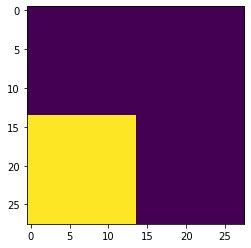

In [4]:
# mask-making
mask = torch.zeros((60000,1,28,28),dtype=bool)
mask[0:9999,:,0:14,0:14]=True
mask[10000:19999,:,14:28,0:14]=True
mask[20000:29999,:,0:14,14:28]=True
mask[30000:39999,:,14:28,14:28]=True
mask[40000:49999,:,:,::2]=True
mask[50000:59999,:,::2,:]=True
test_mask=torch.cat((mask[0:2000],mask[10000:12000],mask[20000:22000],mask[30000:32000],mask[40000:41000],mask[50000:51000]),0)
print(test_mask.shape)
plt.imshow(test_mask[2000][0])

In [5]:
model_num = 10
num_selected = 6
num_rounds = 50
epochs = 5
batch_size = 32

In [6]:
#making train dataset

train_data = MNIST("./bin_data1", train=True, transform=transforms.ToTensor(), download=True)
#converting to tensor
train_digits = []
for batch_idx, (img, targets) in enumerate(train_data):
  train_digits.append(img)
train_digits=torch.stack(train_digits)

#pairing left pictures with right pictures
masked=torch.where(mask,train_digits,torch.zeros((60000,1,28,28)))
ds_train=torch.cat((train_digits,masked,mask),1)
ds_train_split = torch.split(ds_train, [int(ds_train.data.shape[0] / model_num) for _ in range(model_num)])
ds_train_loader = [DataLoader(x, batch_size=batch_size, shuffle=True,pin_memory=cuda,drop_last=True) for x in ds_train_split]

test_data = MNIST("./bin_data1", train=False, transform=transforms.ToTensor(), download=True)
#converting to tensor
test_digits = []
for batch_idx, (img, targets) in enumerate(test_data):
  test_digits.append(img)
test_digits=torch.stack(test_digits)

#pairing left pictures with right pictures
test_masked=torch.where(test_mask,test_digits,torch.zeros((10000,1,28,28)))
ds_test=torch.cat((test_digits,test_masked,test_mask),1)
ds_test_loader=DataLoader(ds_test,batch_size,shuffle=True,num_workers=1,pin_memory=cuda,drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./bin_data1/MNIST/raw/train-images-idx3-ubyte.gz to ./bin_data1/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./bin_data1/MNIST/raw/train-labels-idx1-ubyte.gz to ./bin_data1/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./bin_data1/MNIST/raw/t10k-images-idx3-ubyte.gz to ./bin_data1/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./bin_data1/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./bin_data1/MNIST/raw



In [7]:
# hyper params
latent_size = 512
featureDim= 1024

class VAE(nn.Module):

    def __init__(self):
        super().__init__()

        self.encoderConv = nn.Sequential(
            nn.Conv2d(2,16,4),
            nn.ReLU(),
            nn.Conv2d(16,32,4),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.Conv2d(32,64,4),
            nn.MaxPool2d(2,2),
            nn.ReLU()
        )

        self.encoderMU = nn.Linear(featureDim,latent_size)
        self.encoderLogvar = nn.Linear(featureDim,latent_size)
        
        self.decoderLin = nn.Linear(latent_size,featureDim)

        self.decoderConv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor = 2),
            nn.ConvTranspose2d(64,32,4),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor = 2),
            nn.ConvTranspose2d(32,16,4),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,4),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar/2)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu

    def encode(self, x):
      filtered = self.encoderConv(x)
      x=filtered.view(-1,featureDim)
      mu =self.encoderMU(x)
      logvar = self.encoderLogvar(x)
      return mu, logvar

    def decode(self, z):
      z=self.decoderLin(z)
      return self.decoderConv(z.view(-1,64,4,4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
      z = torch.randn((batch_size,1,n_samples, latent_size)).to(device)
      return self.decode(z)


In [8]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar):
    #reconstruction loss (pushing the points apart)
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x, reduction='sum'
    )

    # KL divergence loss (the relative entropy between two distributions a multivariate gaussian and a normal)
    # (enforce a radius of 1 in each direction + pushing the means towards zero)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD # we can use a beta parameter here (BCE + beta * KLD)

In [9]:
#This function trains client model on client data

def client_update(client_model, optimizer, train_loader, epoch):
    model.train()
    train_loss=0;
    for e in range(epoch):
        for imgs in train_loader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            #masked input to model
            out, mu, logvar = model(imgs[:,1:,:,:])
            #masking the output for loss computing
            out_masked = torch.where(imgs[:,2,:,:].unsqueeze(1)>0.5,out,torch.zeros((batch_size,1,28,28)).to(device))
            loss = loss_function(out_masked, imgs[:,1,:,:].unsqueeze(1), mu, logvar)
            #passing loss backwards
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
    return train_loss

In [10]:
 # This will take simple mean of the weights of models 
def server_aggregate(global_model, client_models): 
      global_dict = global_model.state_dict()
      #setting global model state to mean of the client model states
      for k in global_dict.keys():
          global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
      global_model.load_state_dict(global_dict)
      #setting client models to the mean as well
      for model in client_models:
         model.load_state_dict(global_model.state_dict())

In [11]:
#use-case: testing the global model
def test(global_model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for imgs in test_loader:
            imgs=imgs.to(device)
            out, mu, logvar = global_model(imgs[:,1:,:,:])
            out_masked=torch.where(imgs[:,2,:,:].unsqueeze(1)>0.5,out,torch.zeros((batch_size,1,28,28)).to(device))
            test_loss += loss_function(out_masked, imgs[:,1,:,:].unsqueeze(1),mu,logvar).item()  
            
    display_images(imgs[:,1,:,:],imgs[:,0,:,:], out,None, 1)

    return test_loss

In [12]:
#creating the models
global_model = VAE().to(device)

client_models = [ VAE().to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) # initial synchronizing with global model 

#adding optimizers 
opt = [torch.optim.Adam(model.parameters(), lr=0.001) for model in client_models]

0. round of updating and aggregating
average train loss 78.7 | test loss 159.9 
1. round of updating and aggregating
average train loss 89.1 | test loss 137.5 
2. round of updating and aggregating
average train loss 67.4 | test loss 119.2 
3. round of updating and aggregating
average train loss 72.9 | test loss 112 
4. round of updating and aggregating
average train loss 44.9 | test loss 95.77 
5. round of updating and aggregating
average train loss 51.2 | test loss 89.74 
6. round of updating and aggregating
average train loss 49.9 | test loss 78.86 
7. round of updating and aggregating
average train loss 38.5 | test loss 74.78 
8. round of updating and aggregating
average train loss 34.1 | test loss 71.23 
9. round of updating and aggregating
average train loss 32.5 | test loss 68.44 
10. round of updating and aggregating
average train loss 32.1 | test loss 63.37 
11. round of updating and aggregating
average train loss 38.9 | test loss 60.93 
12. round of updating and aggregating
av

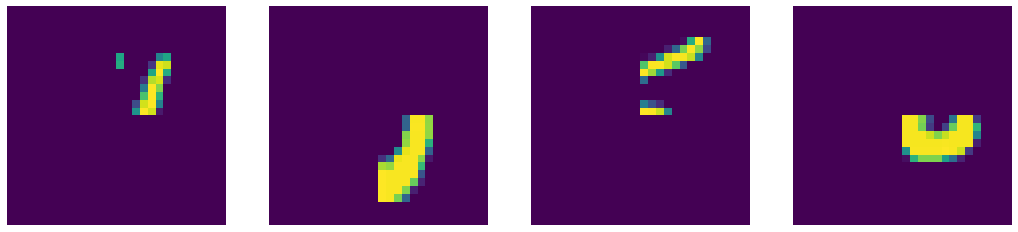

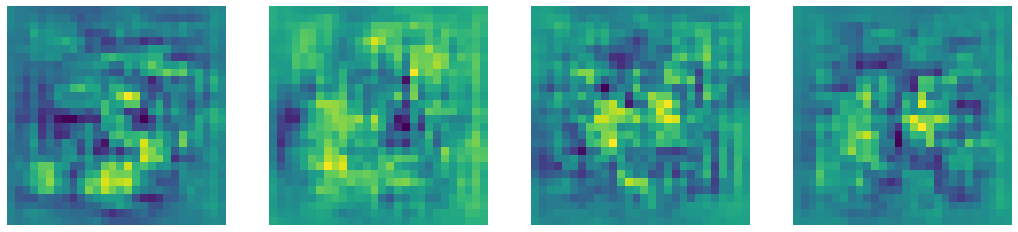

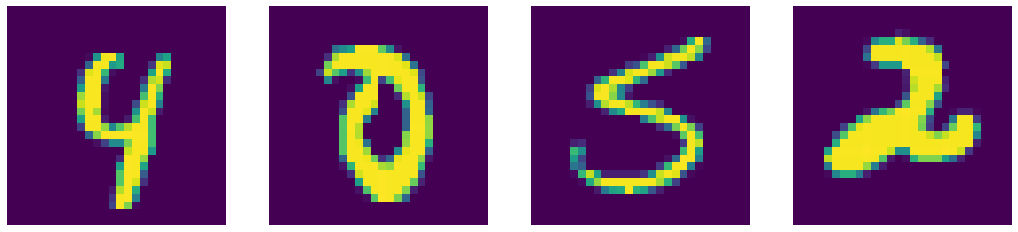

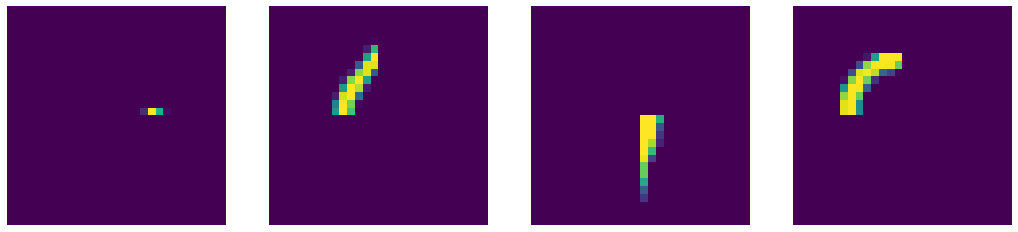

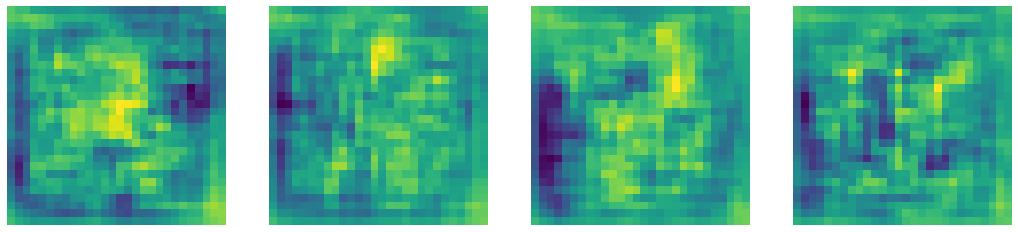

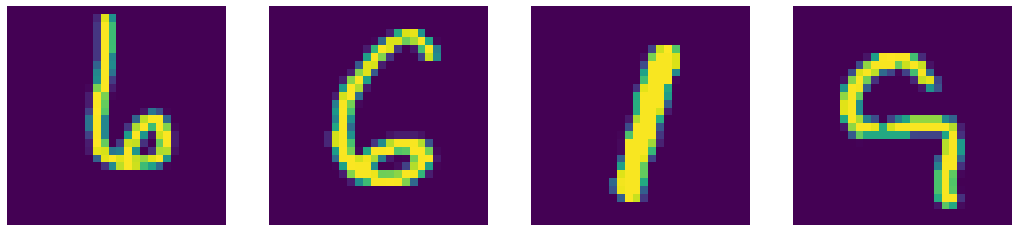

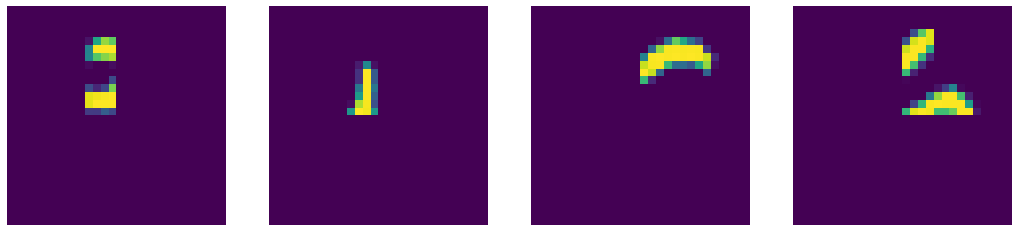

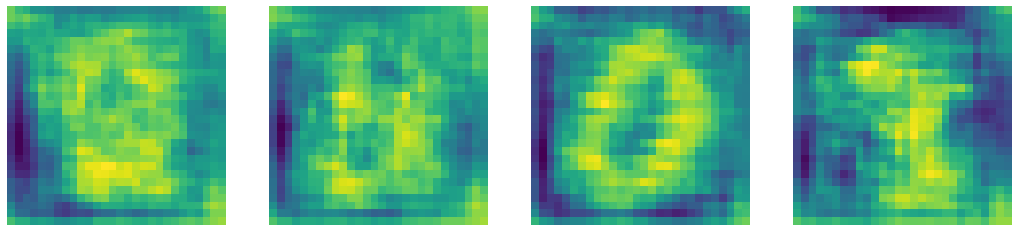

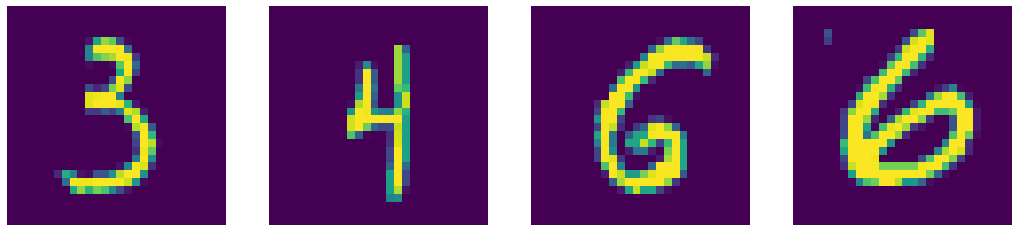

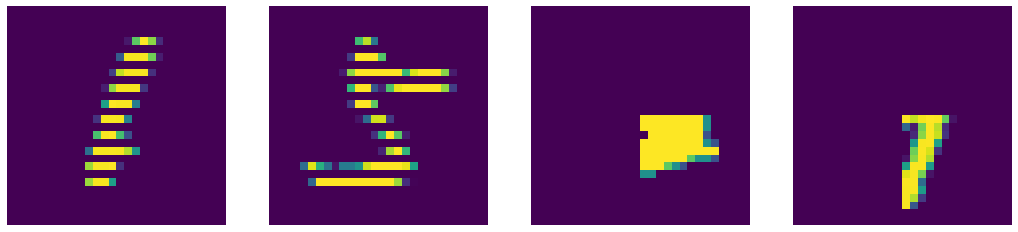

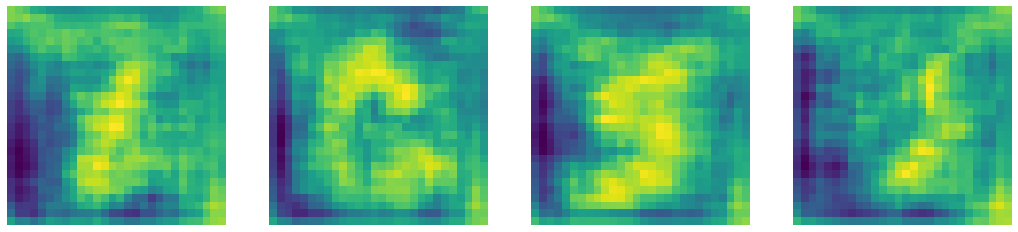

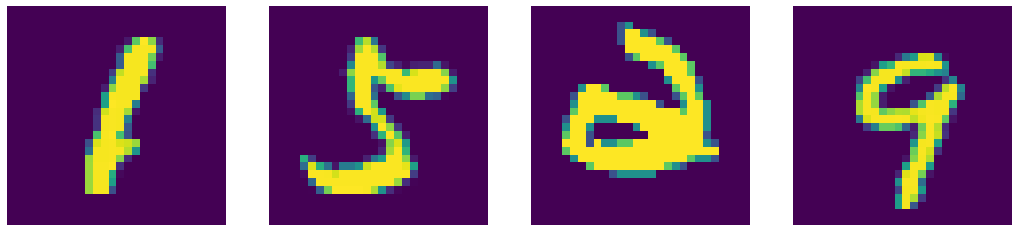

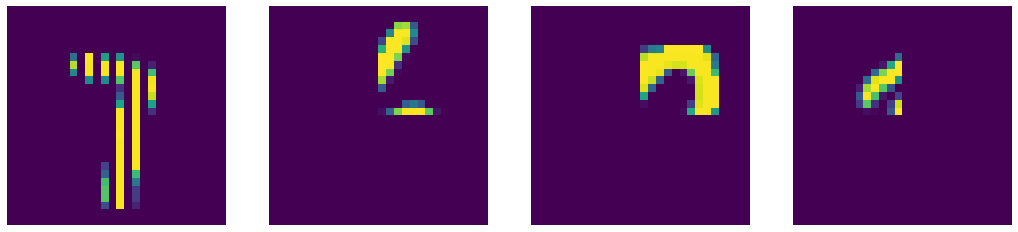

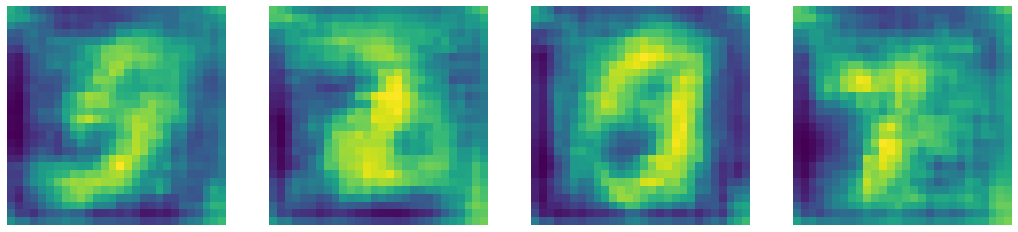

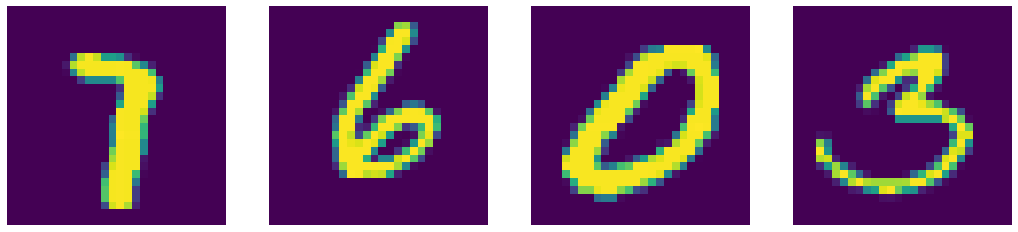

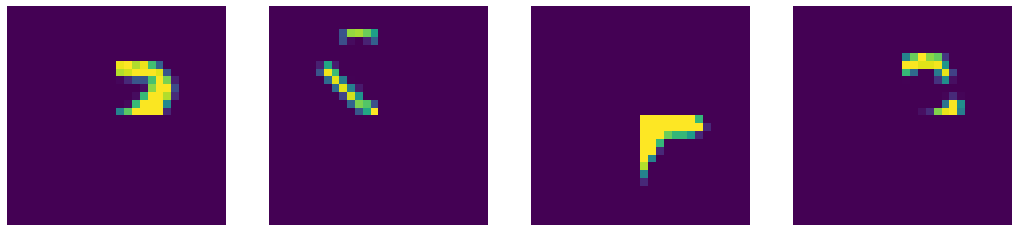

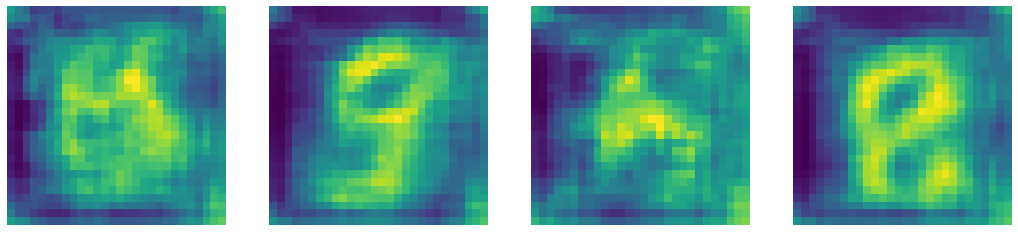

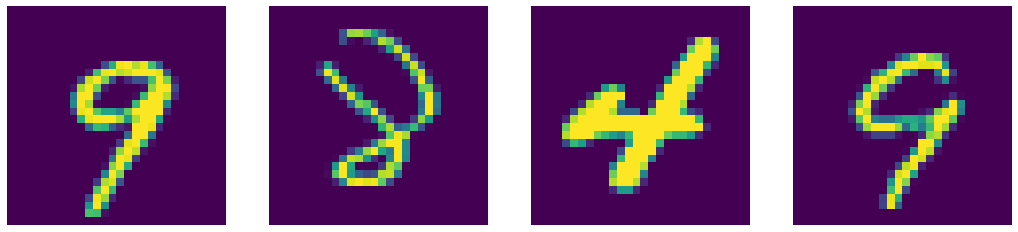

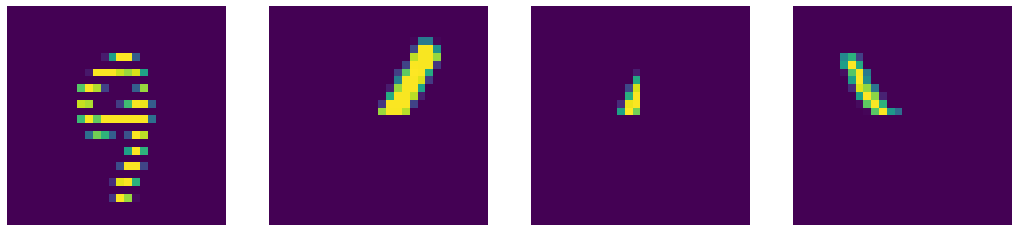

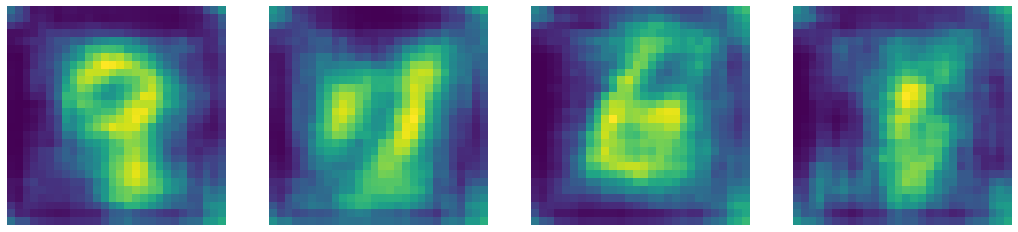

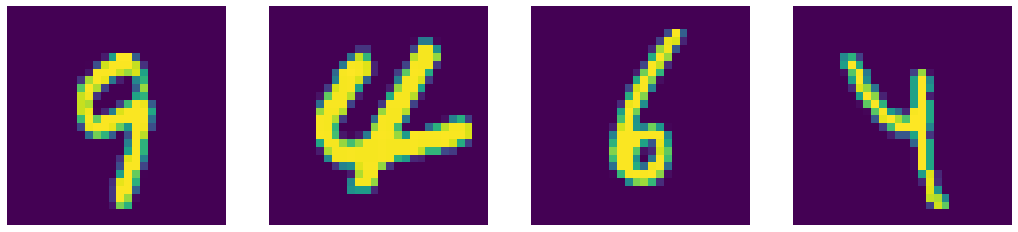

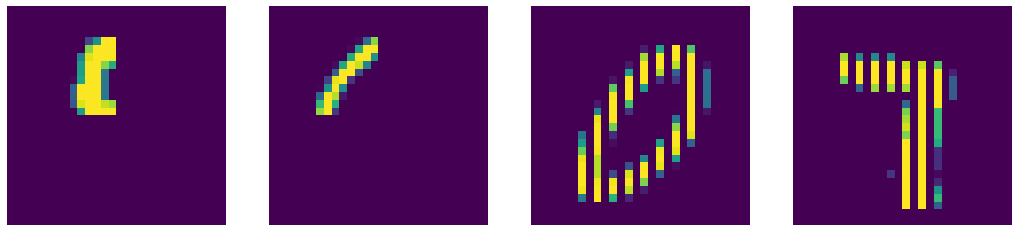

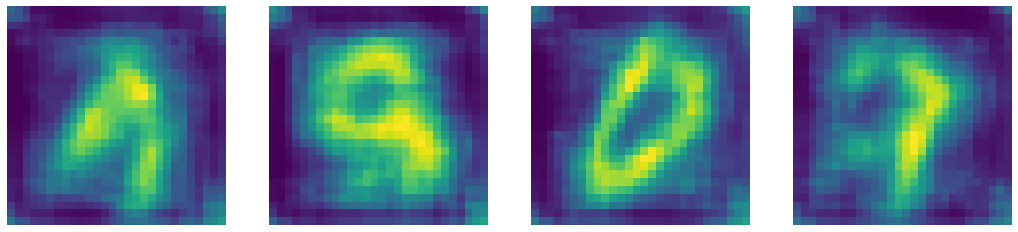

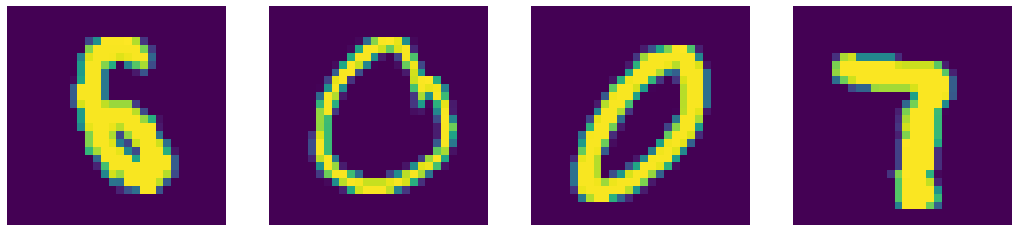

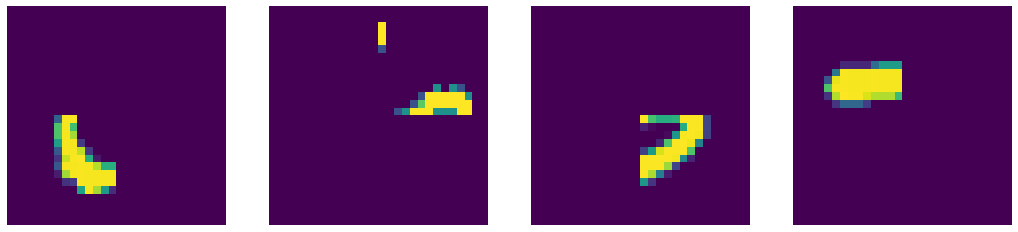

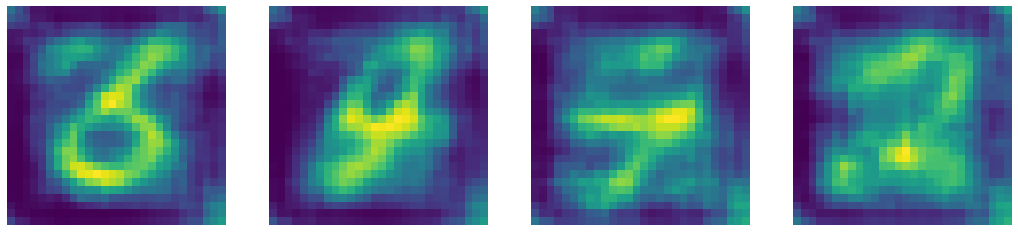

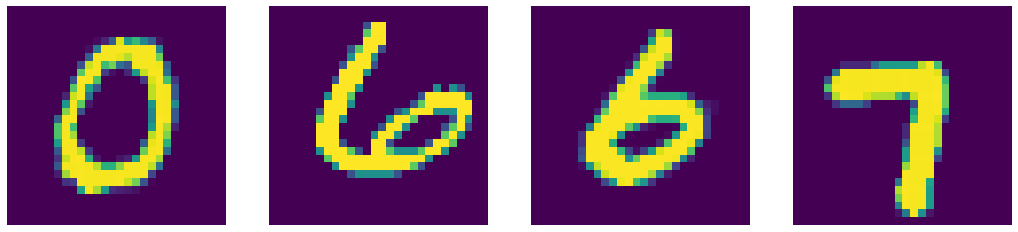

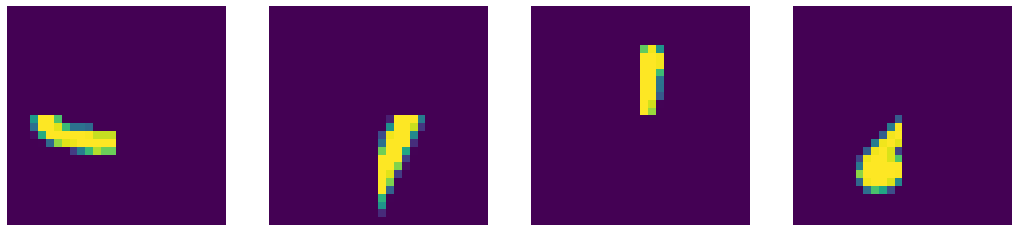

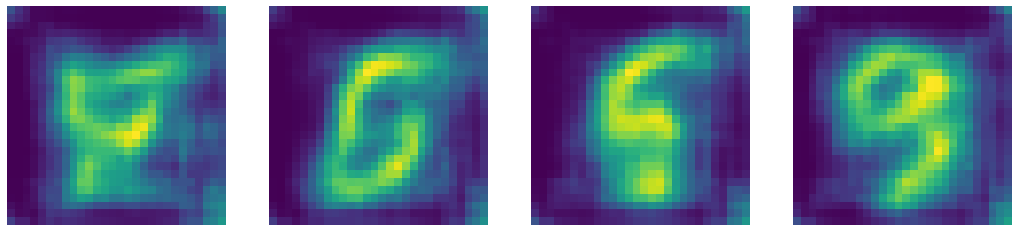

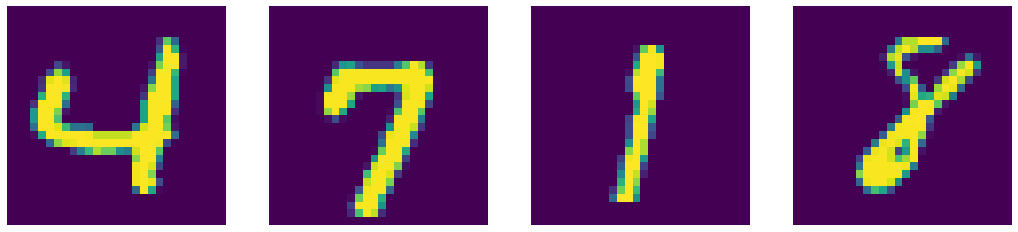

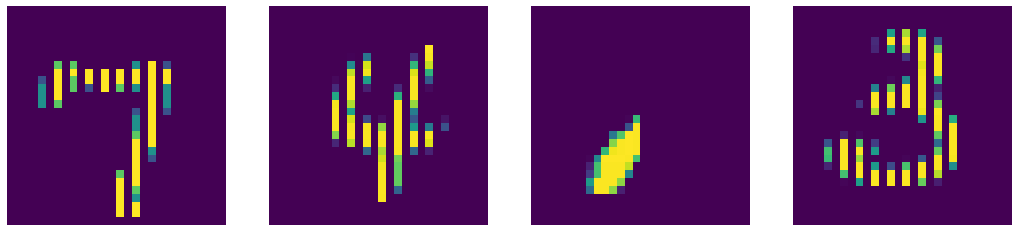

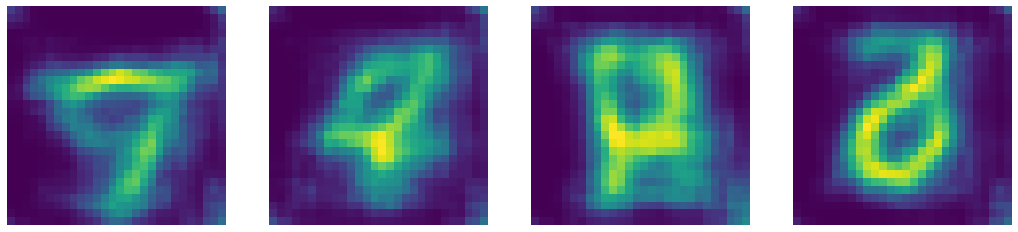

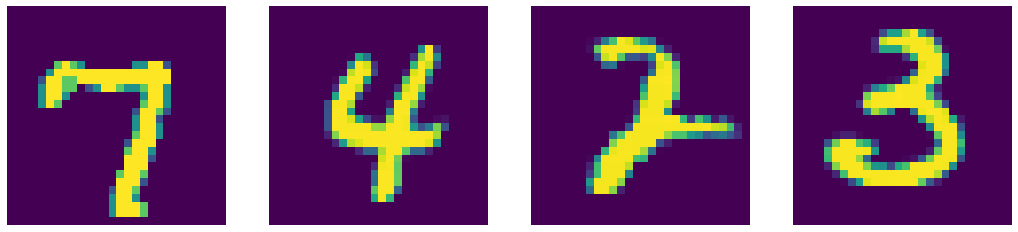

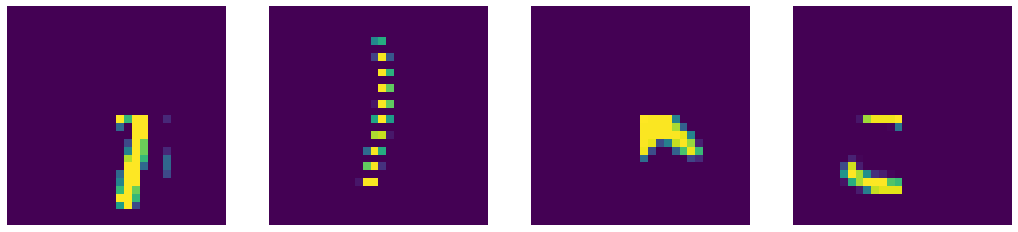

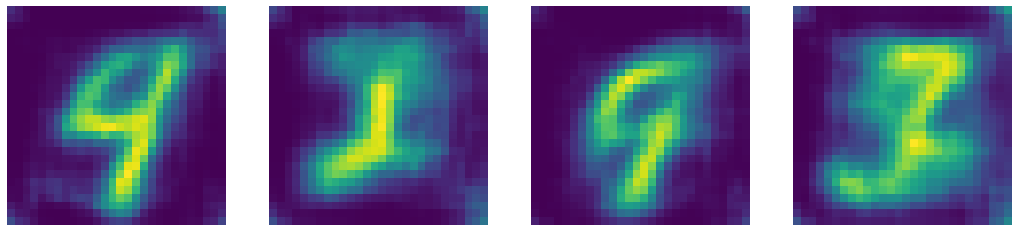

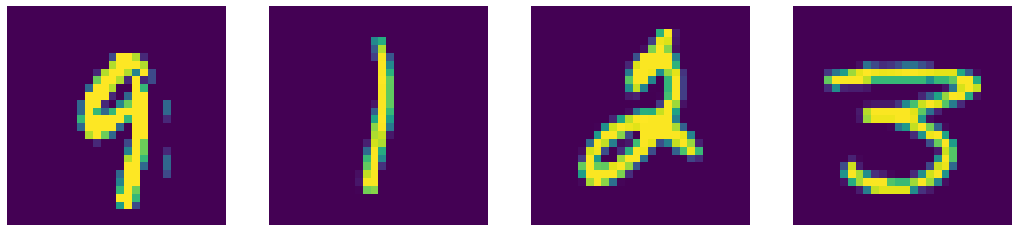

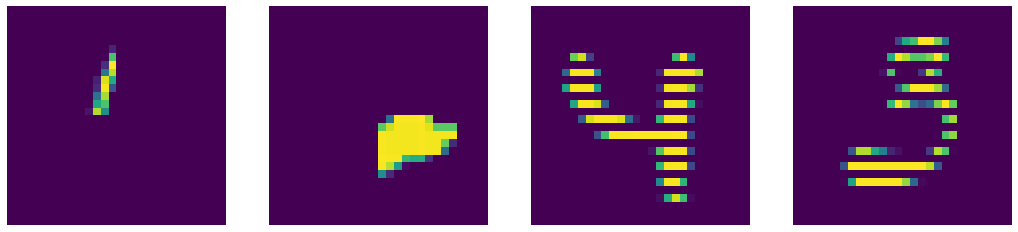

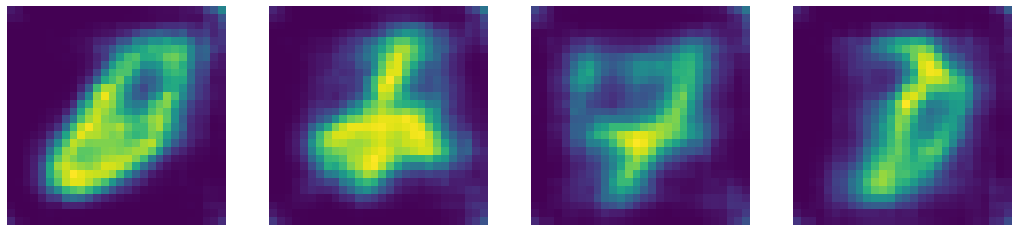

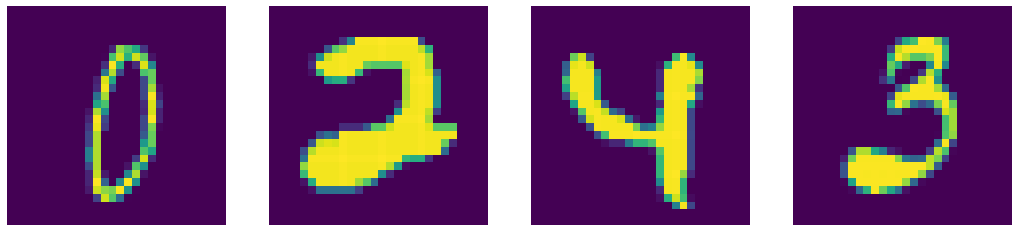

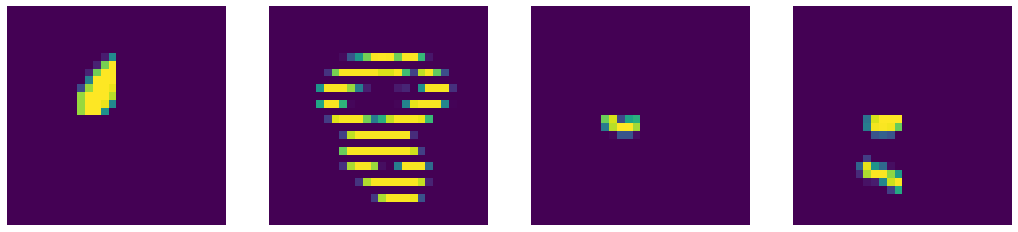

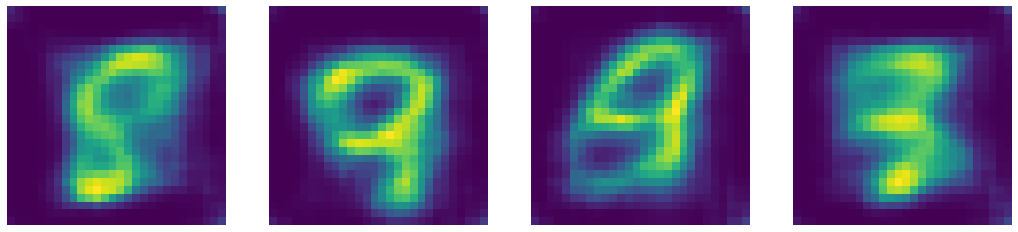

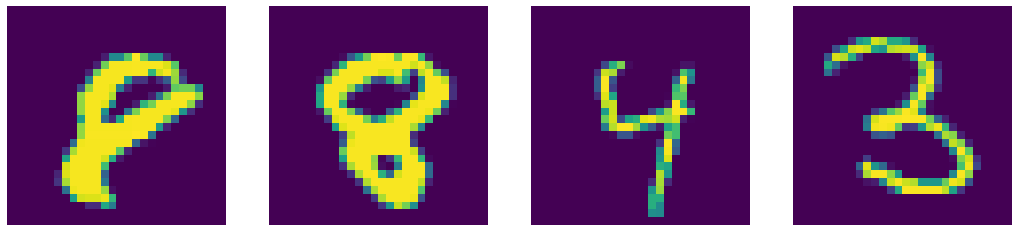

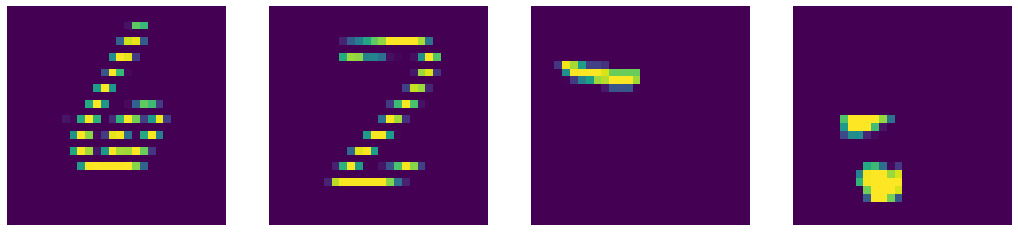

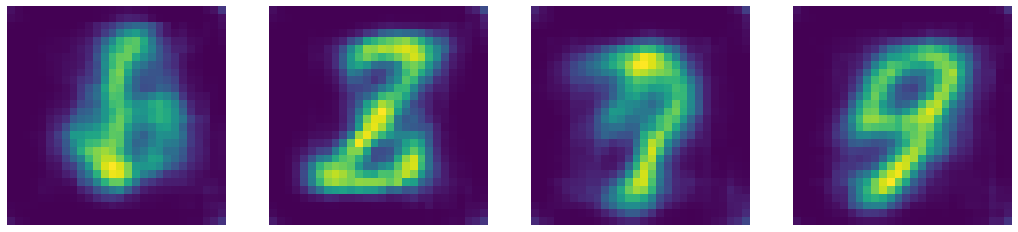

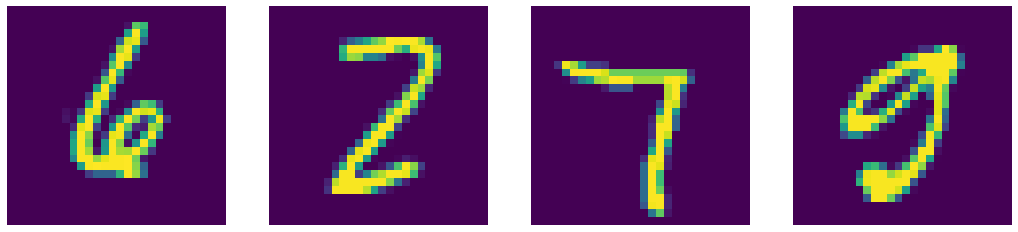

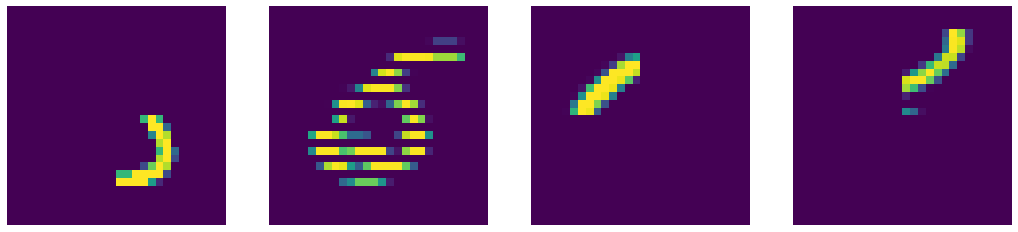

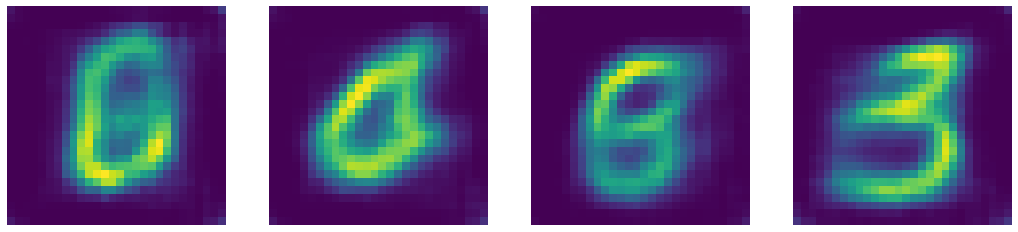

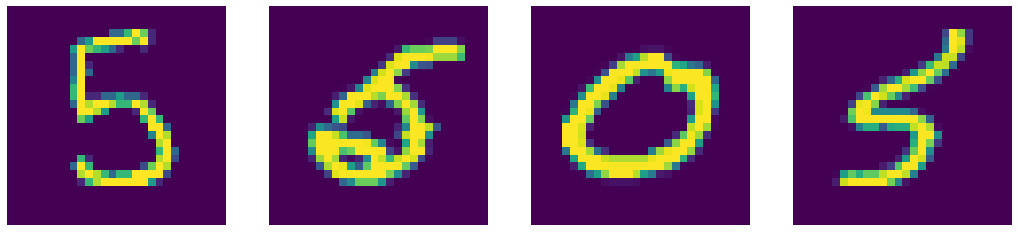

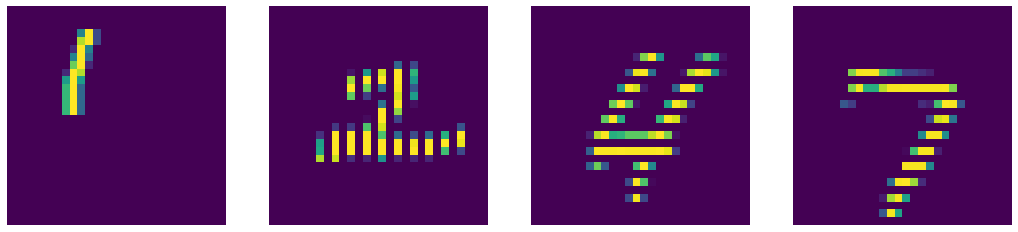

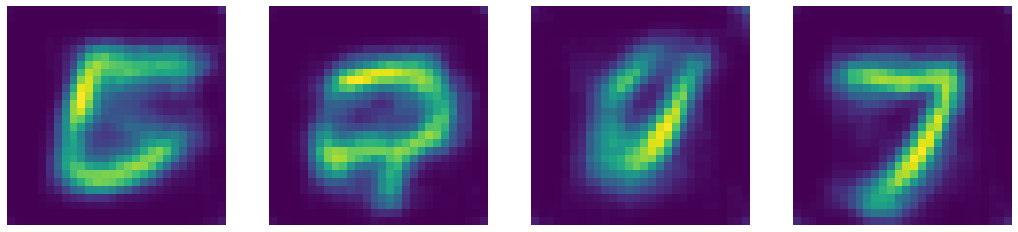

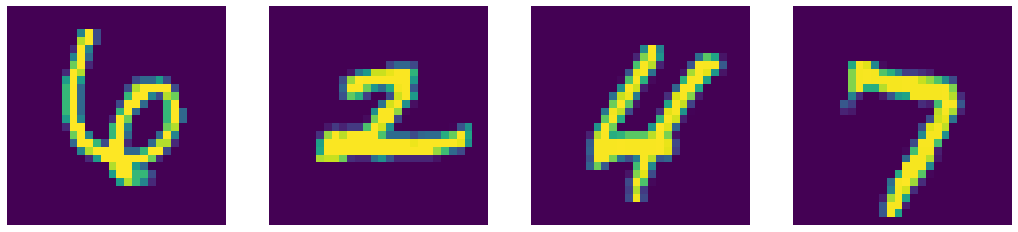

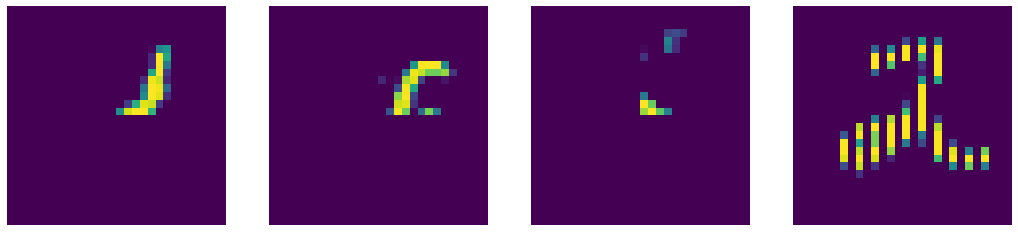

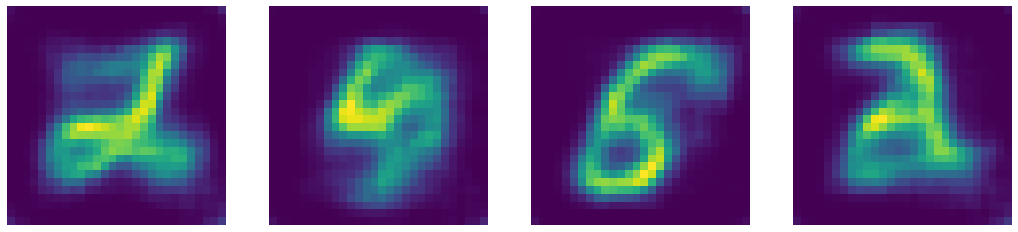

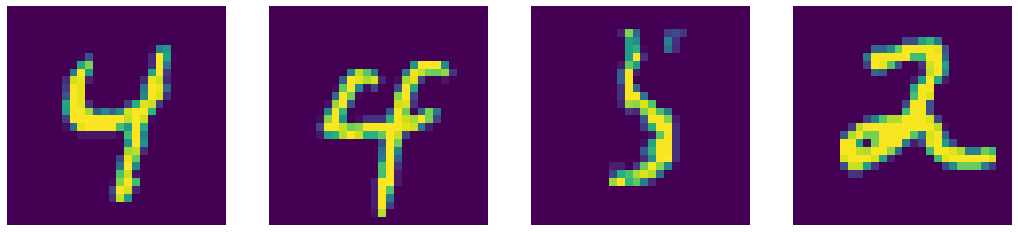

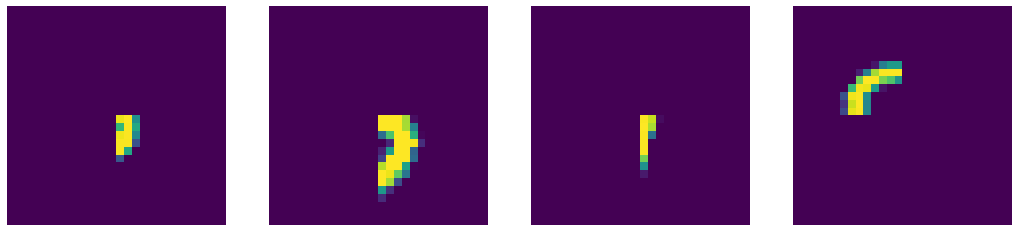

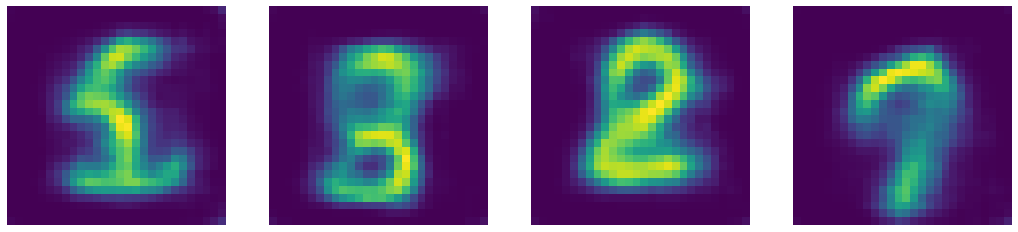

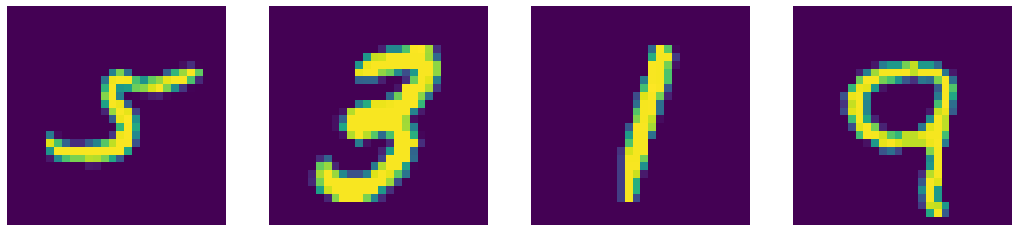

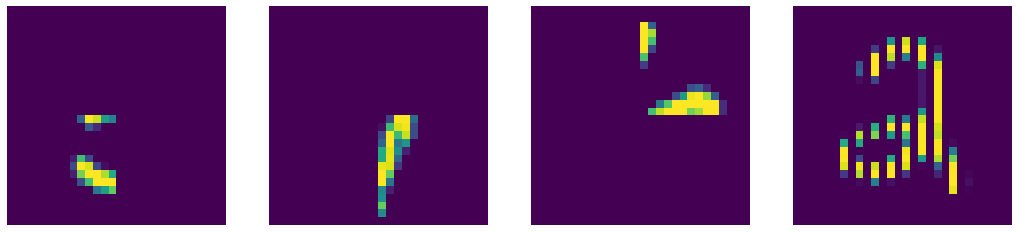

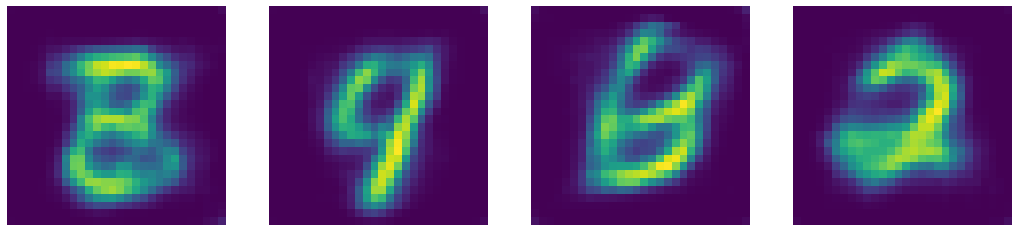

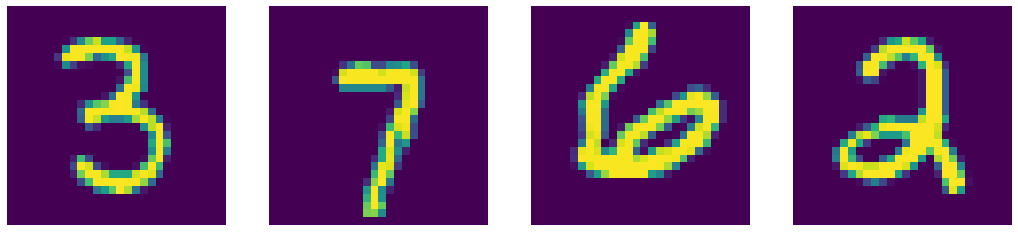

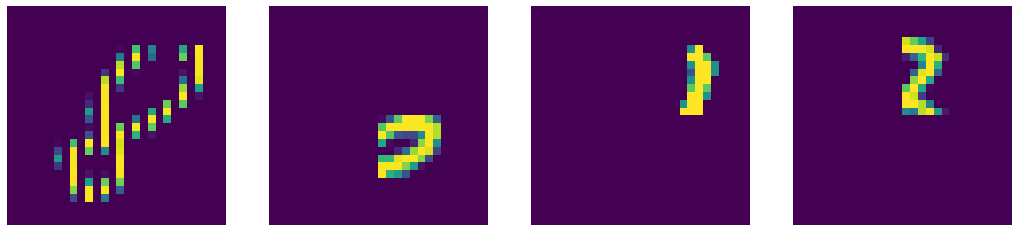

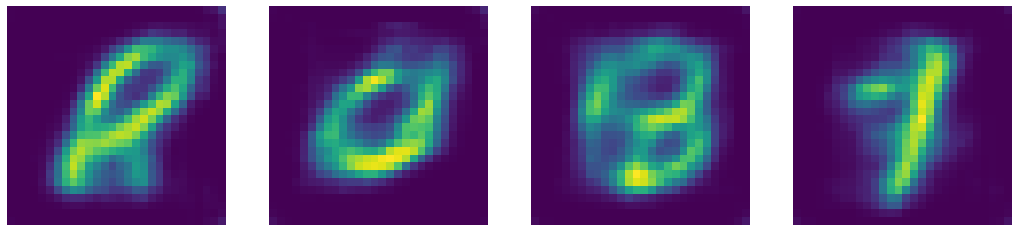

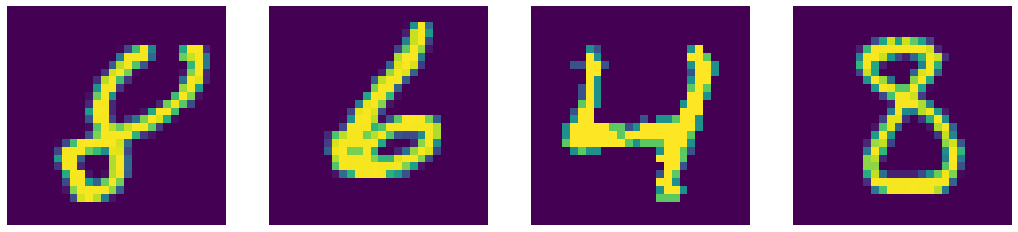

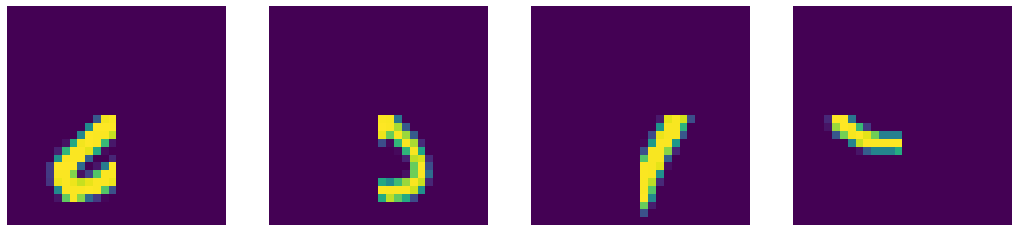

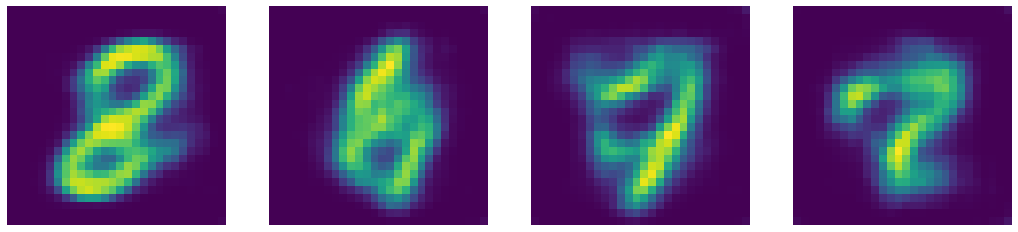

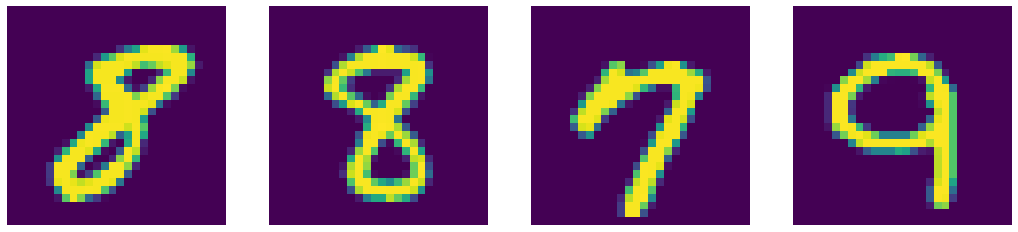

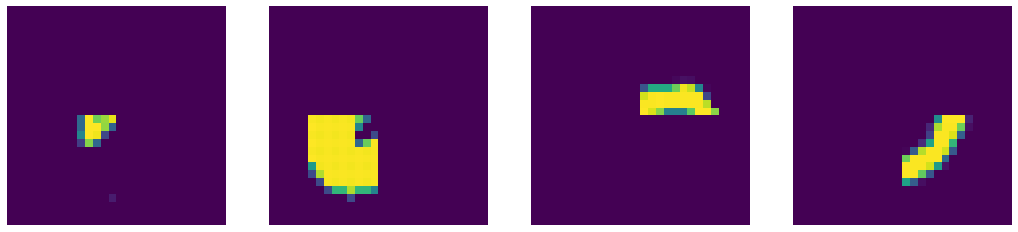

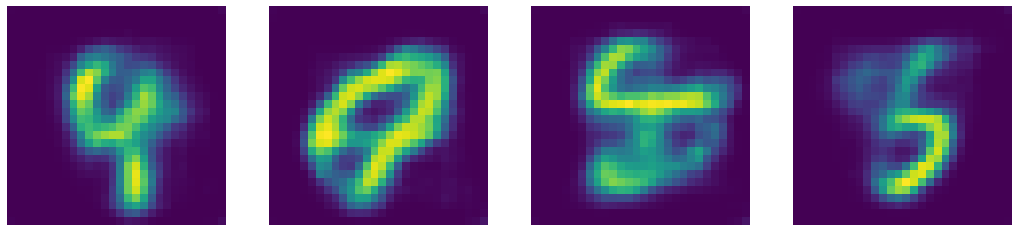

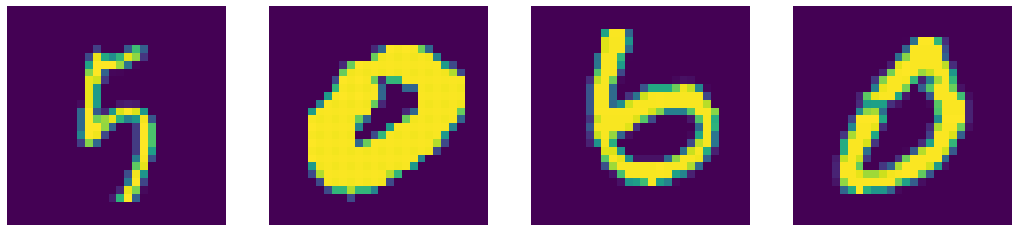

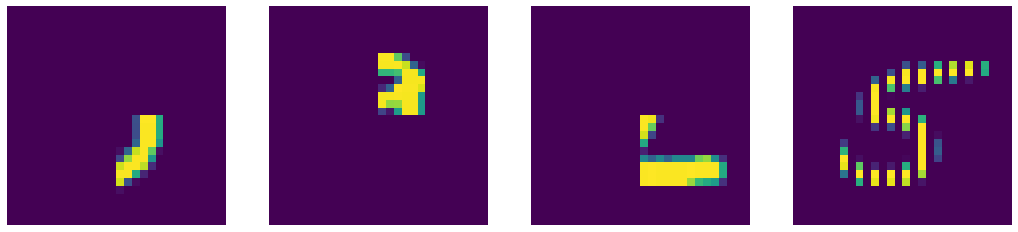

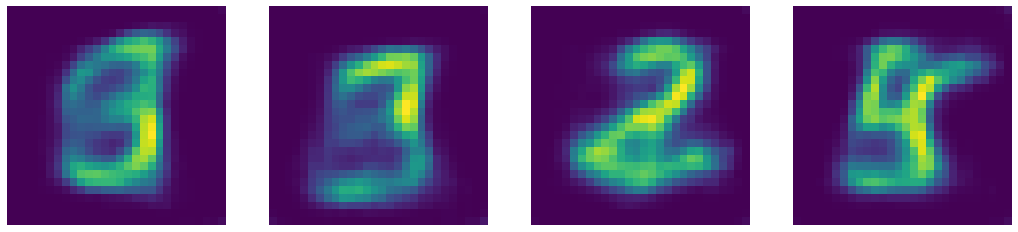

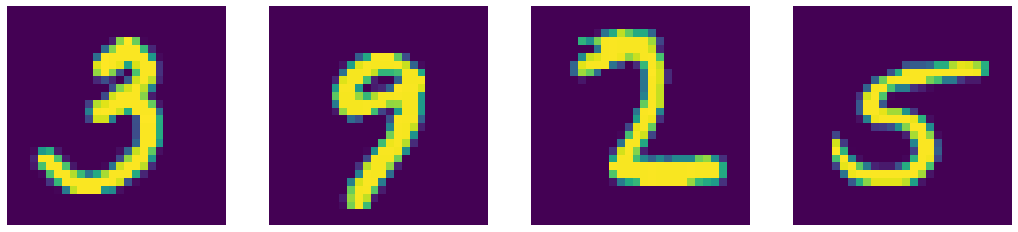

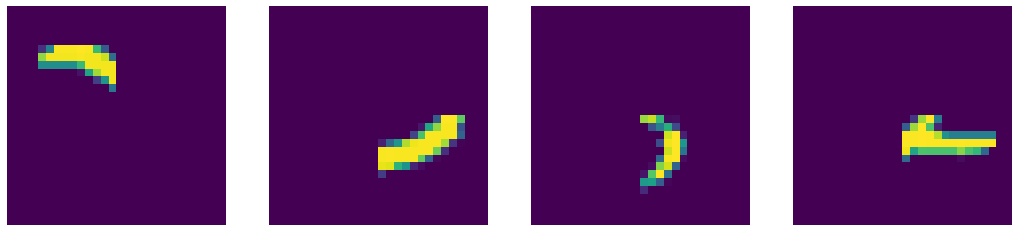

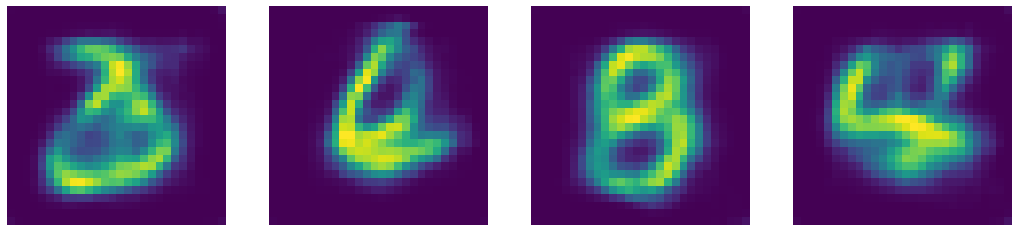

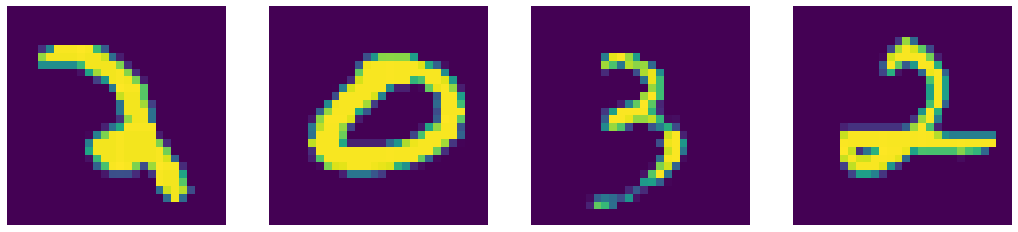

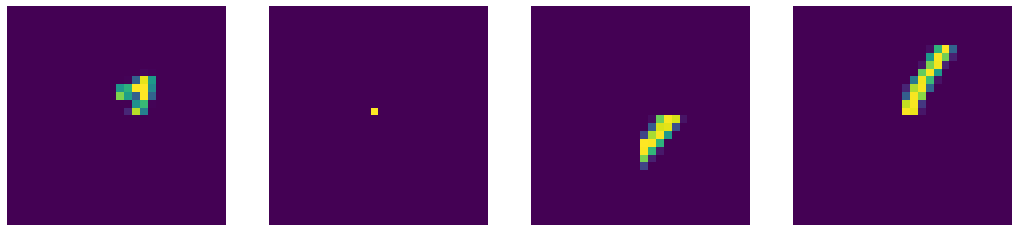

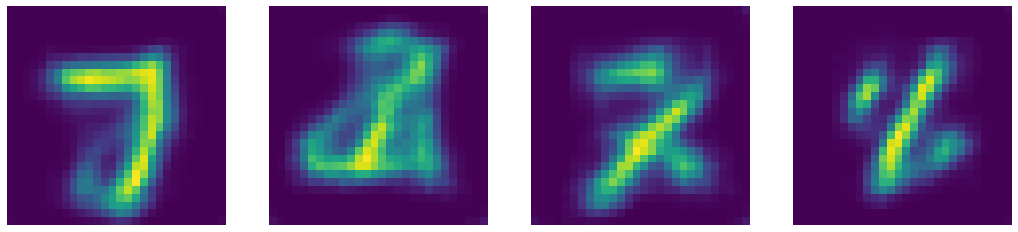

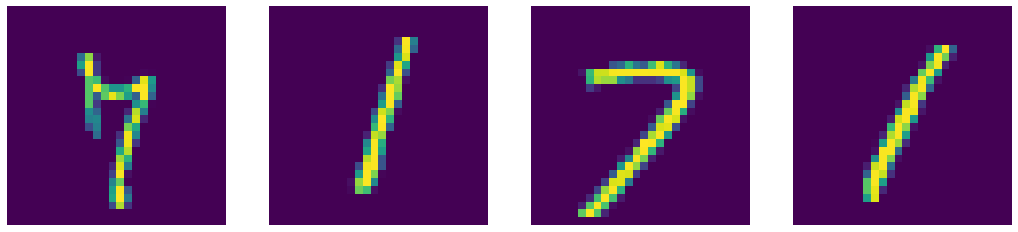

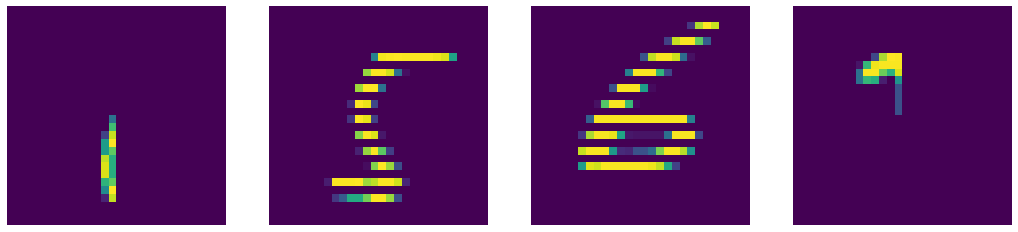

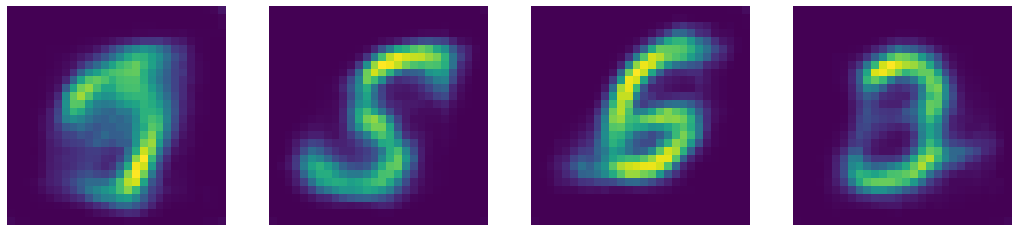

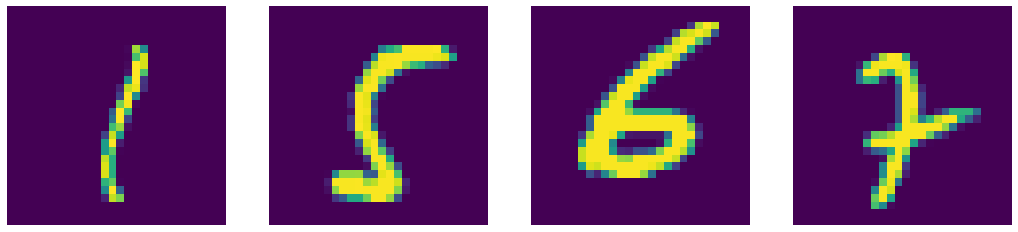

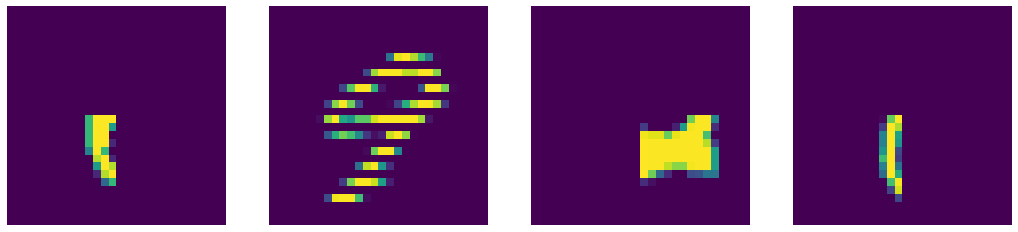

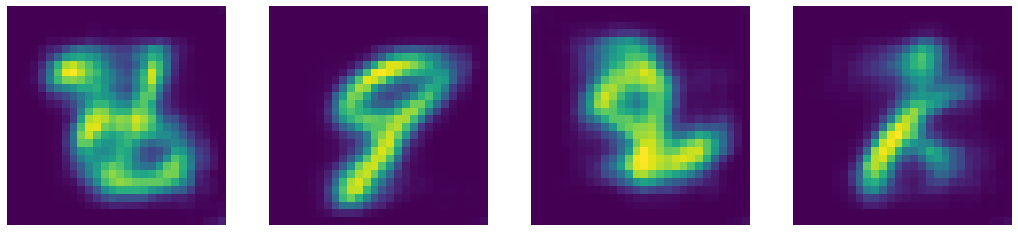

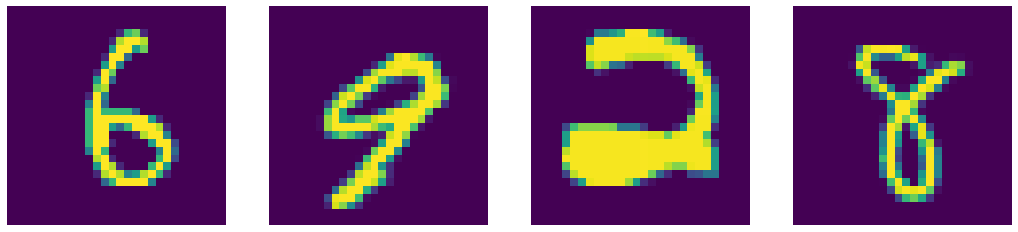

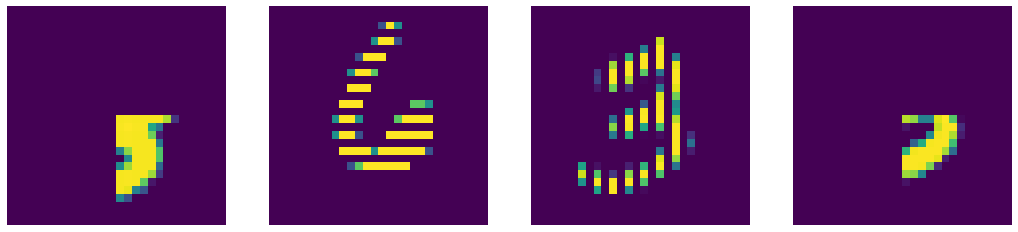

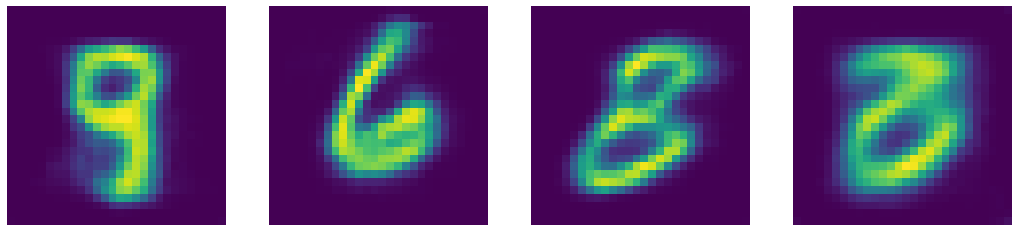

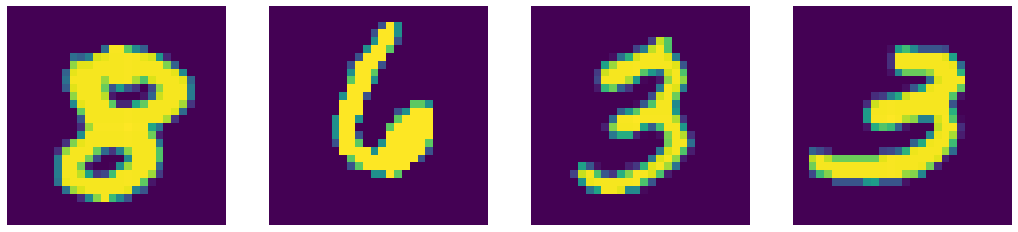

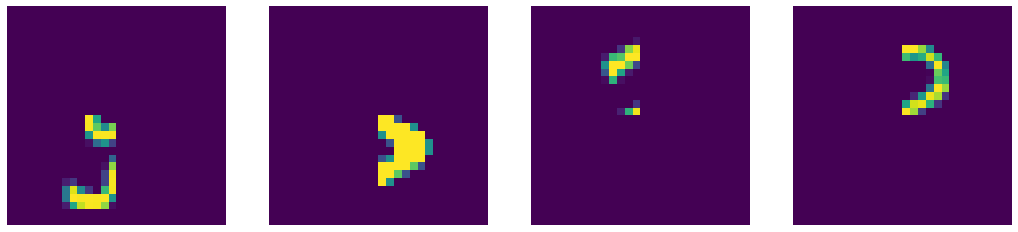

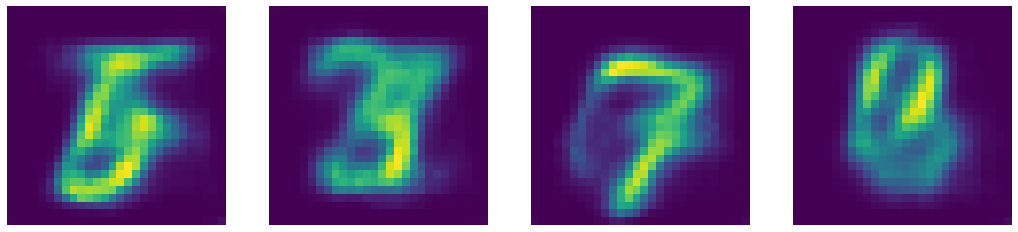

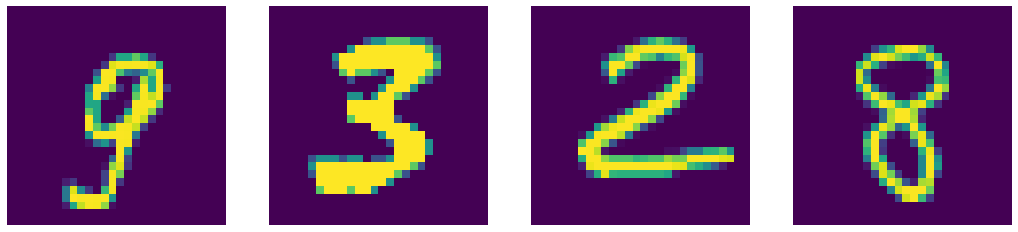

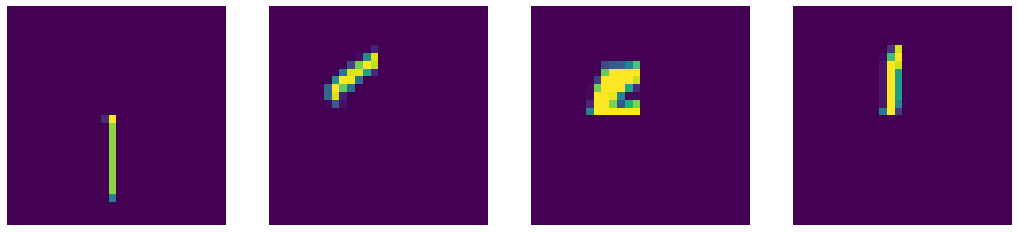

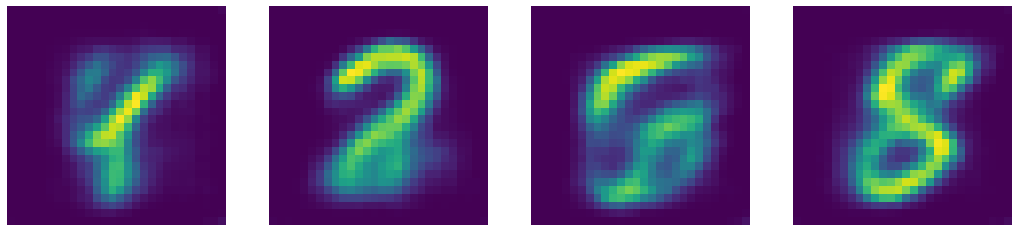

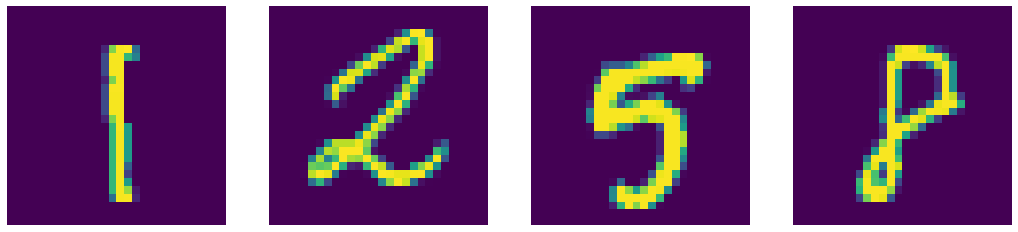

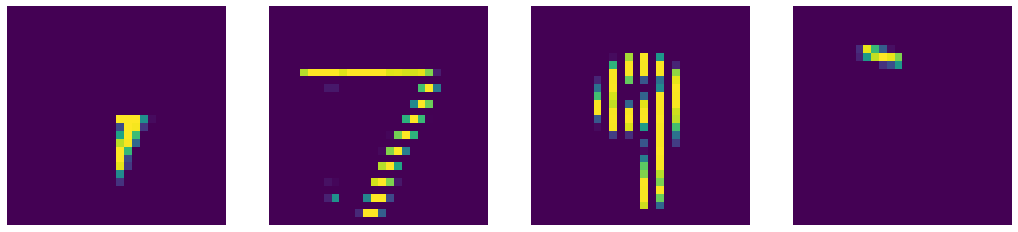

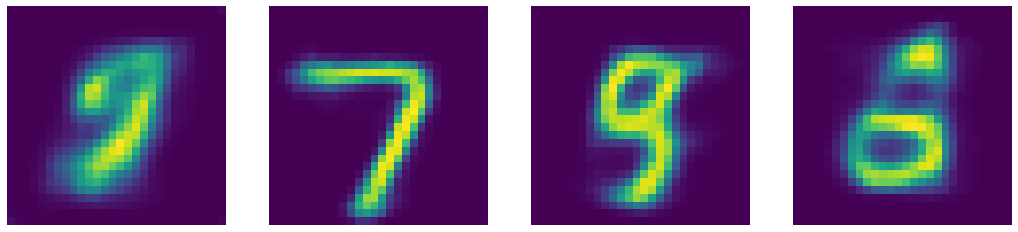

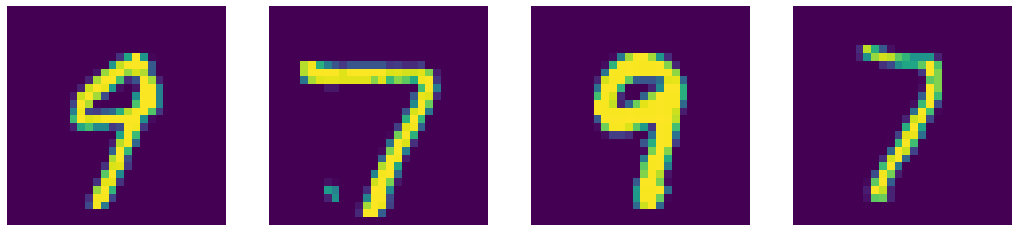

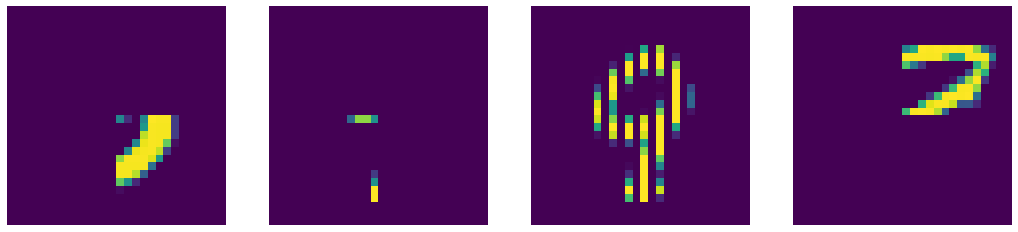

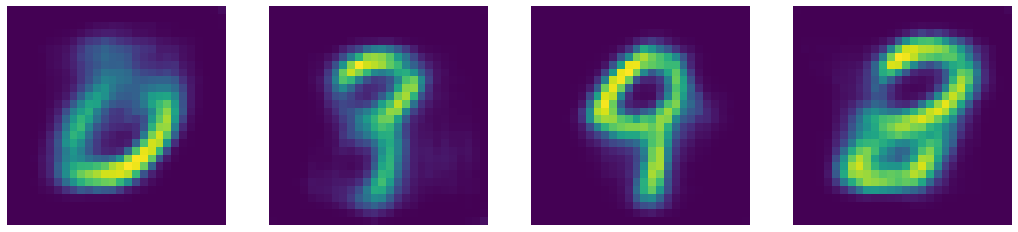

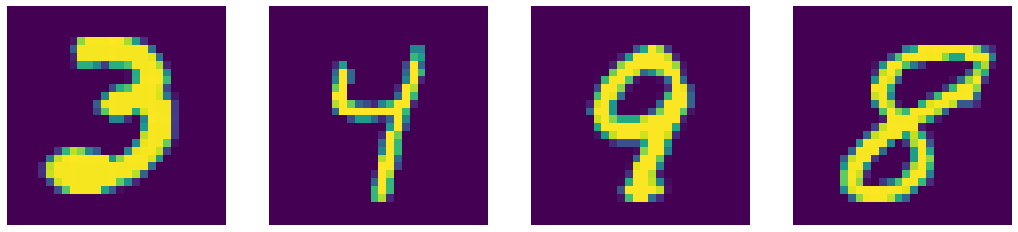

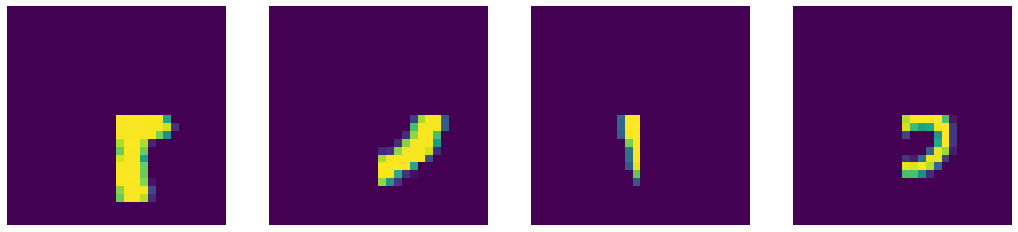

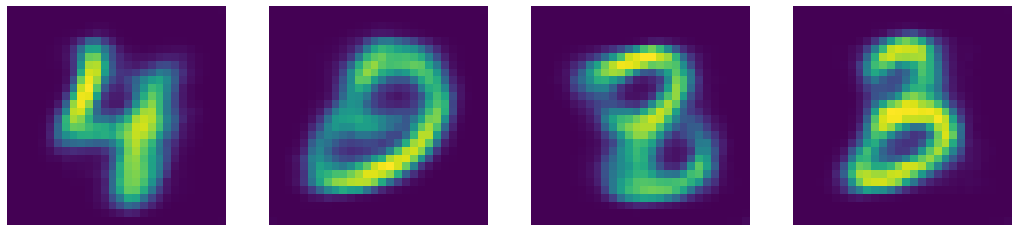

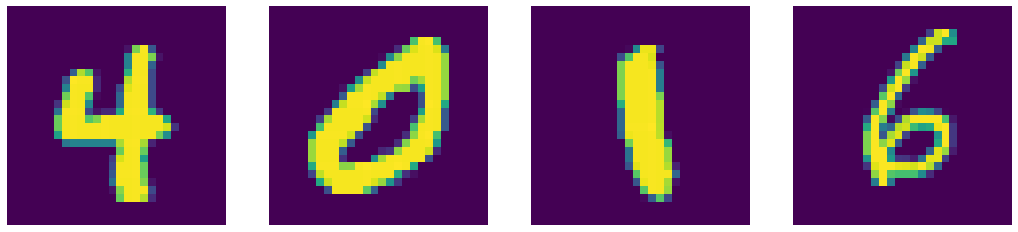

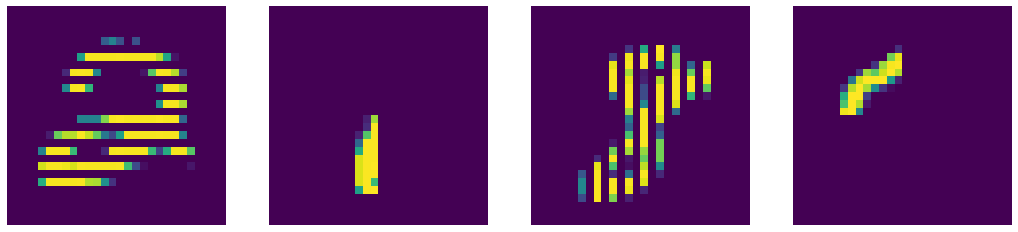

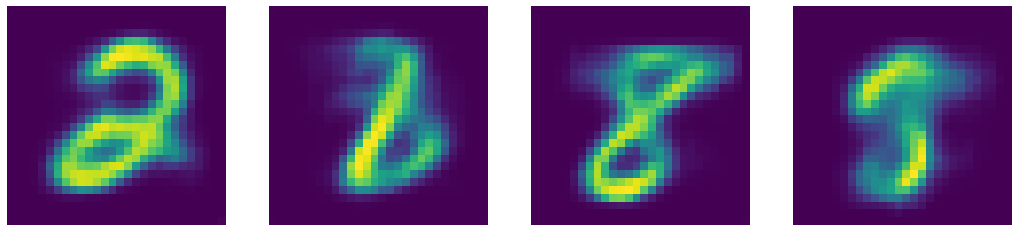

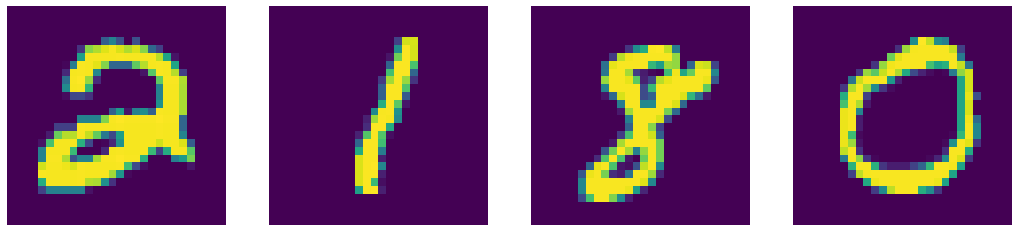

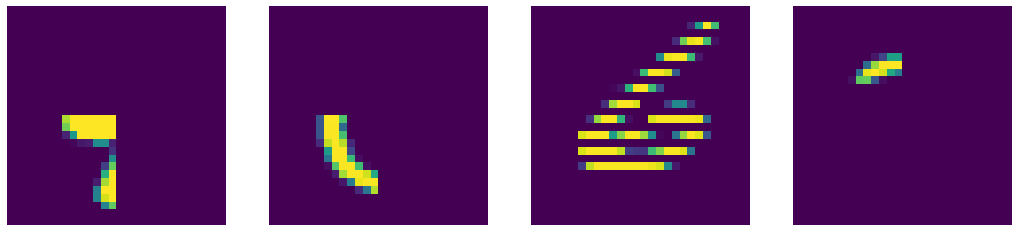

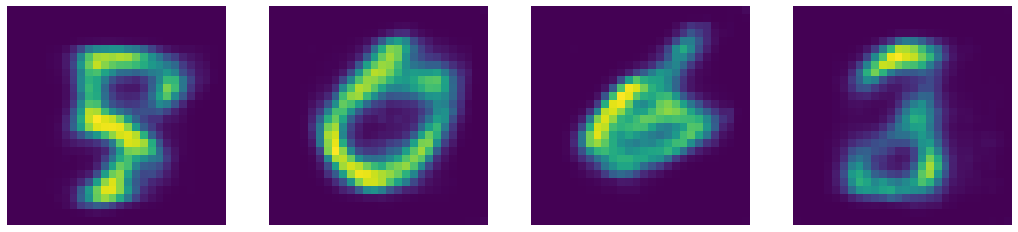

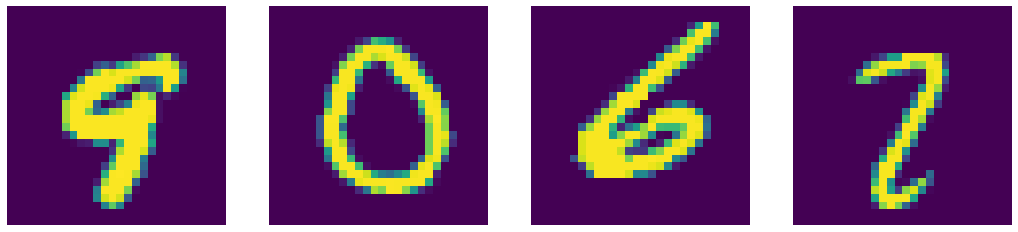

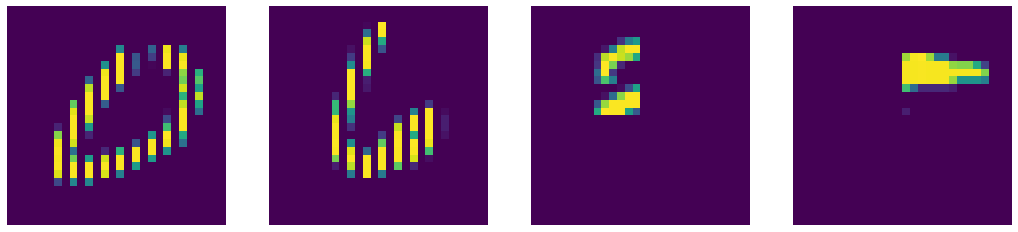

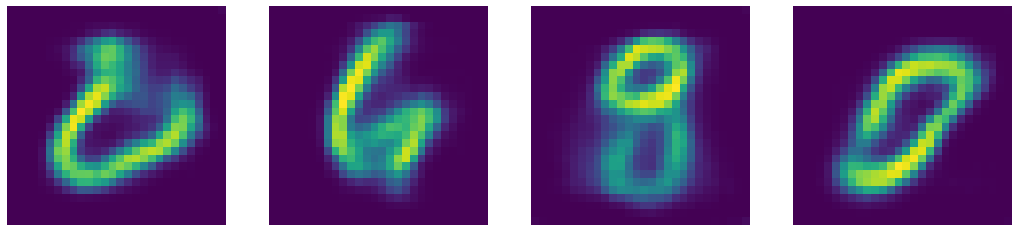

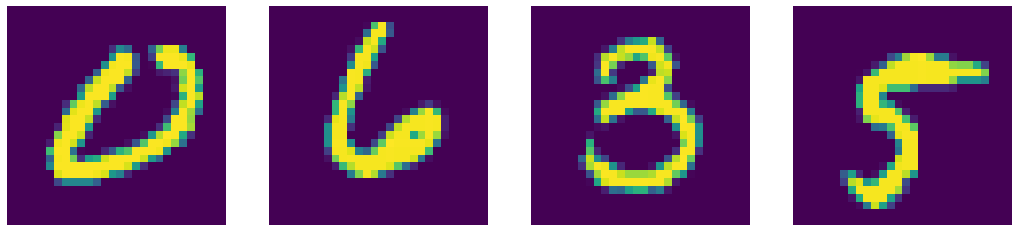

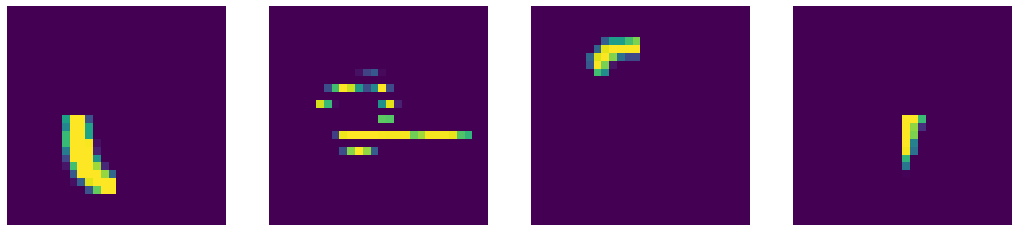

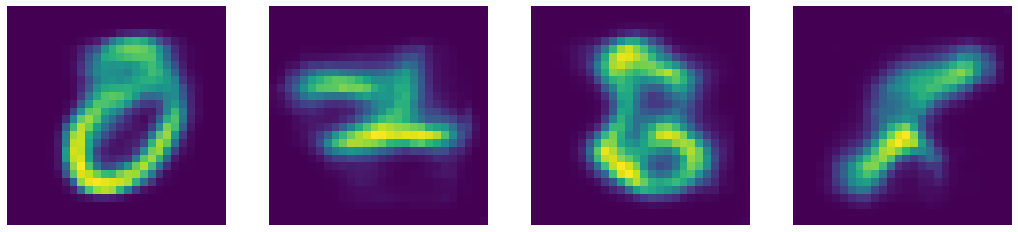

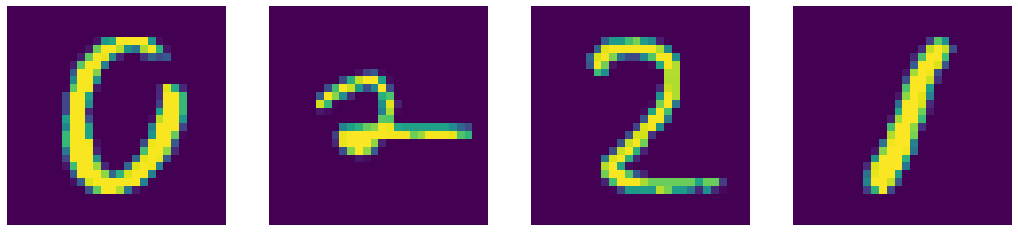

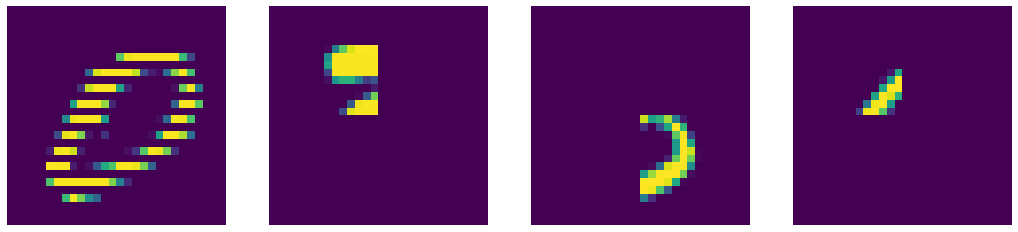

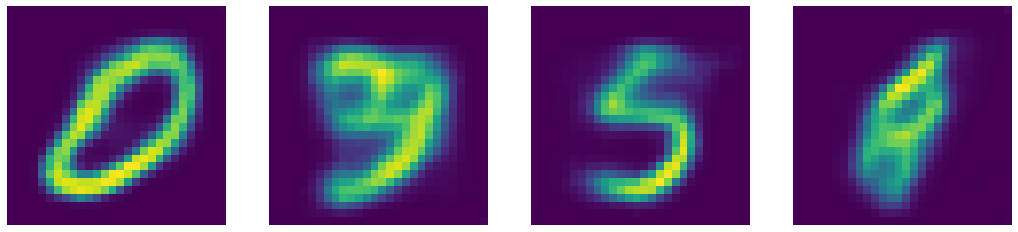

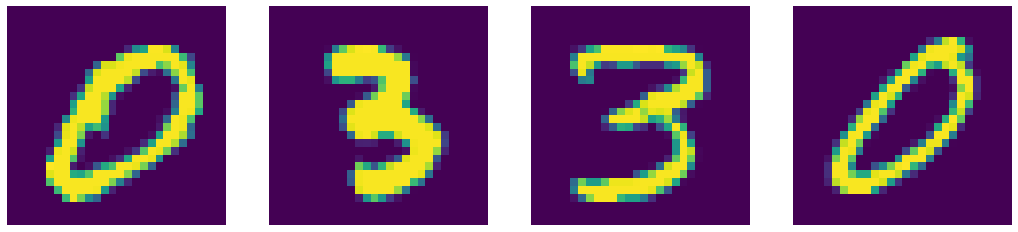

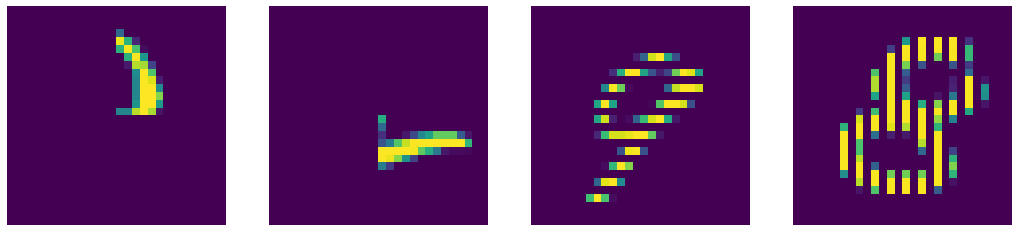

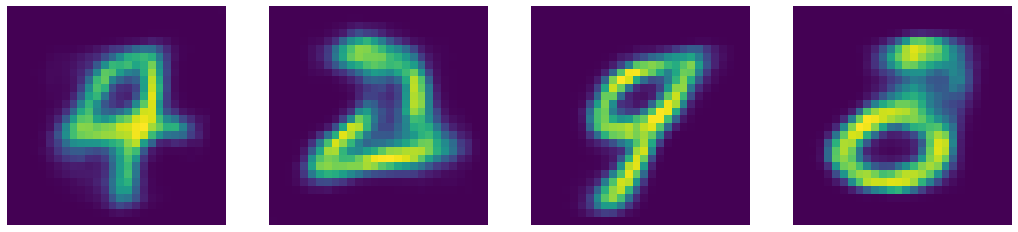

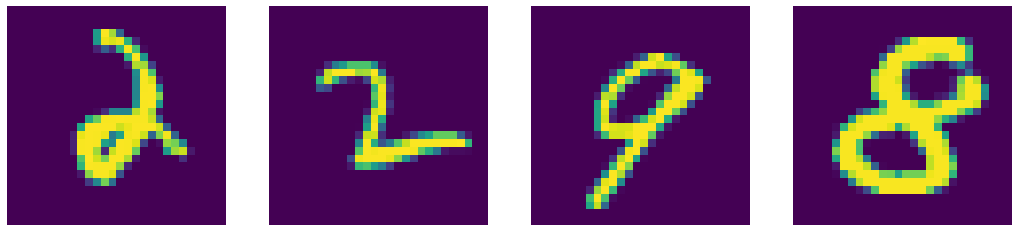

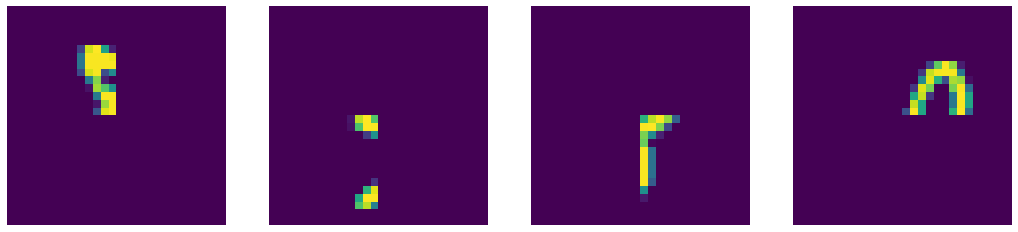

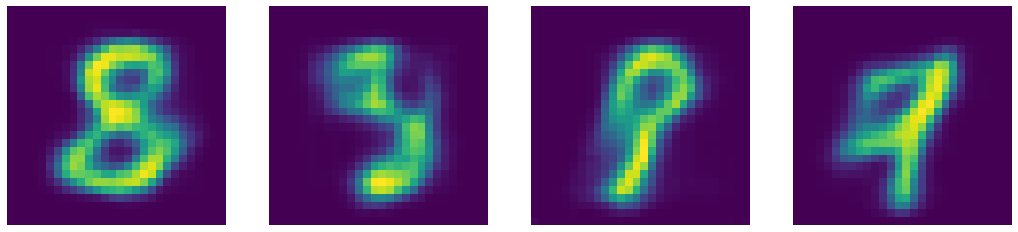

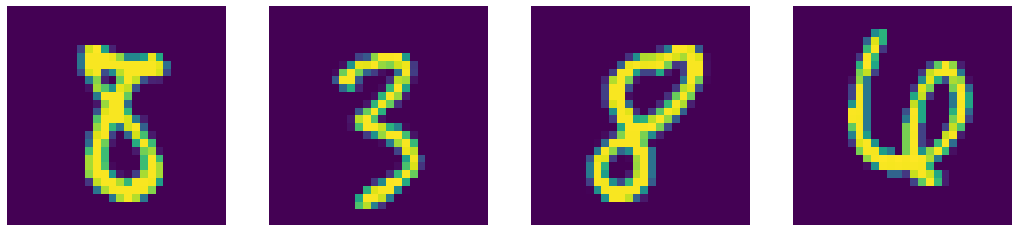

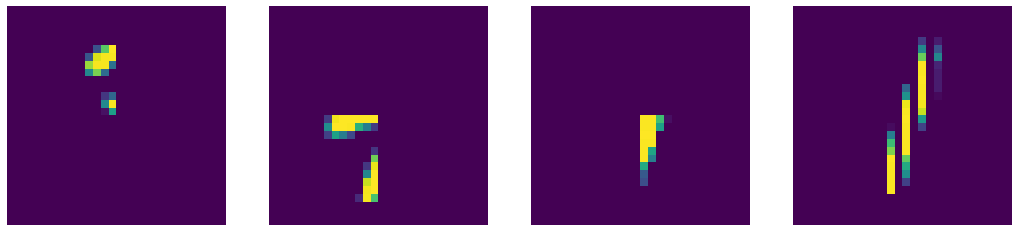

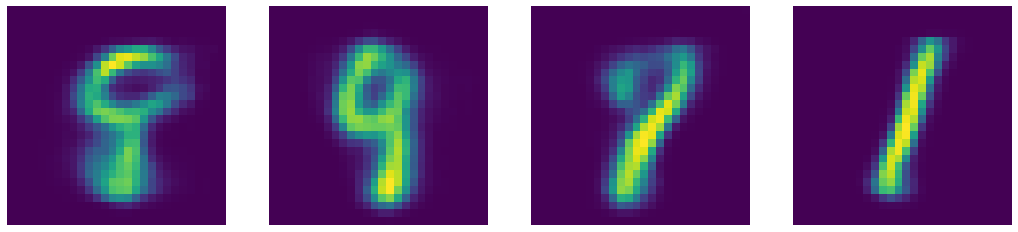

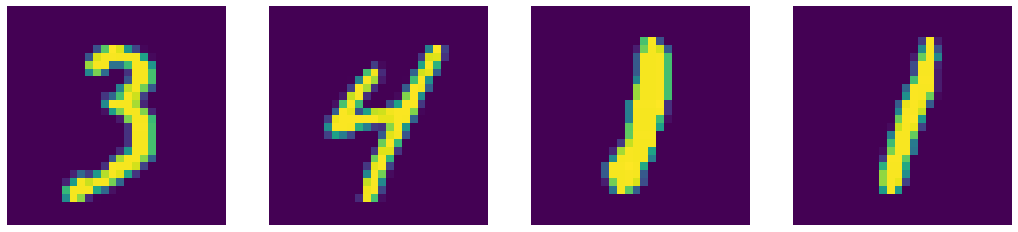

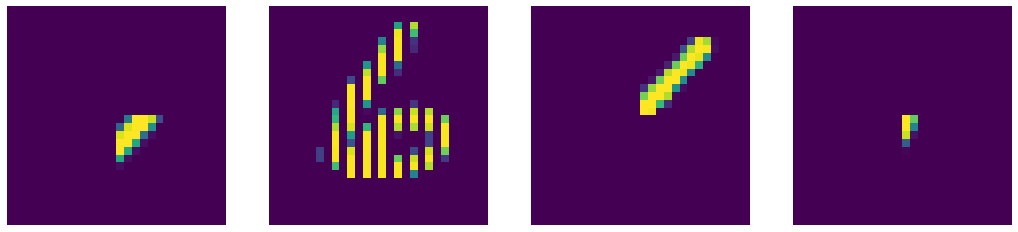

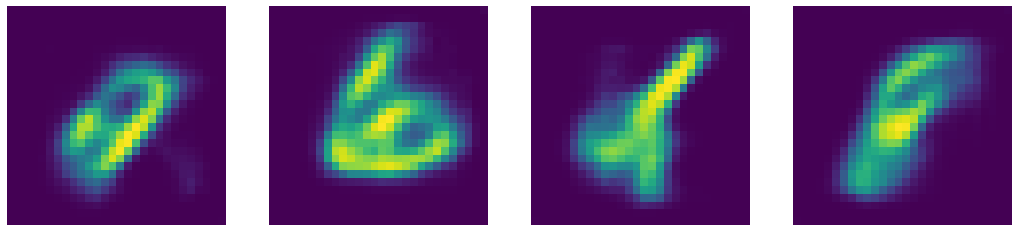

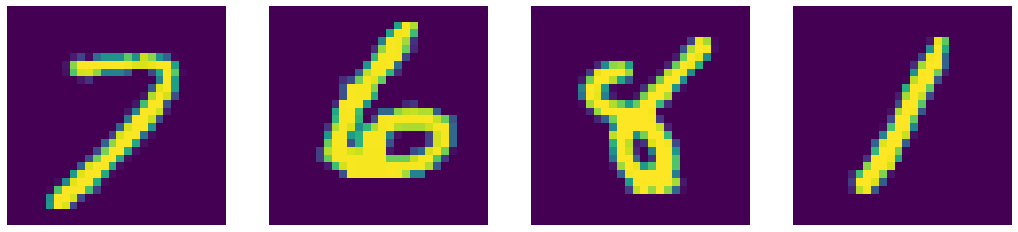

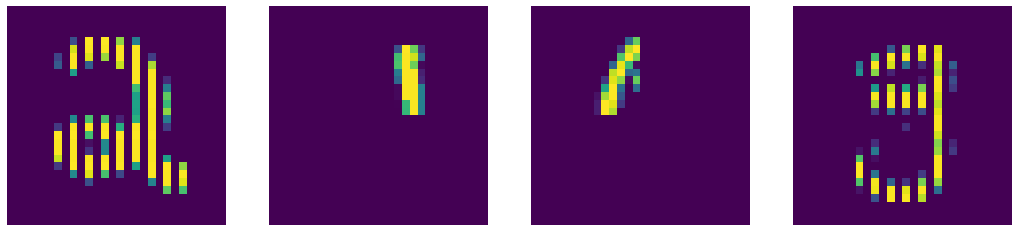

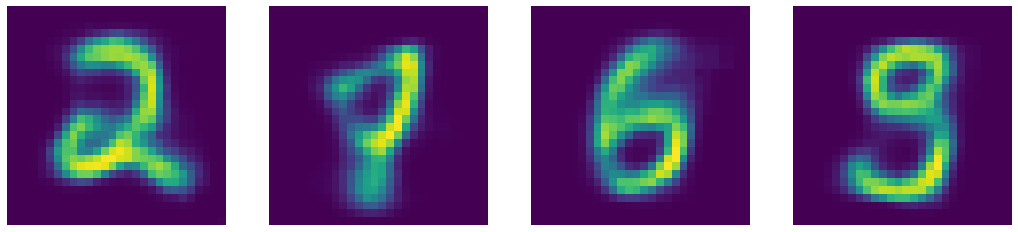

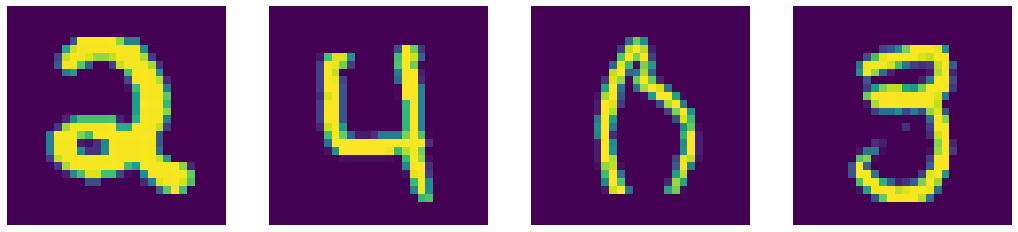

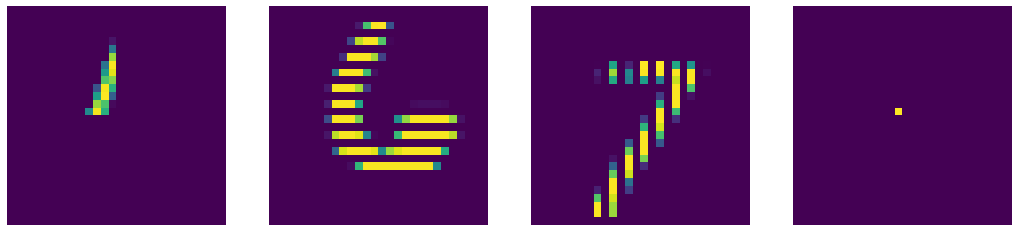

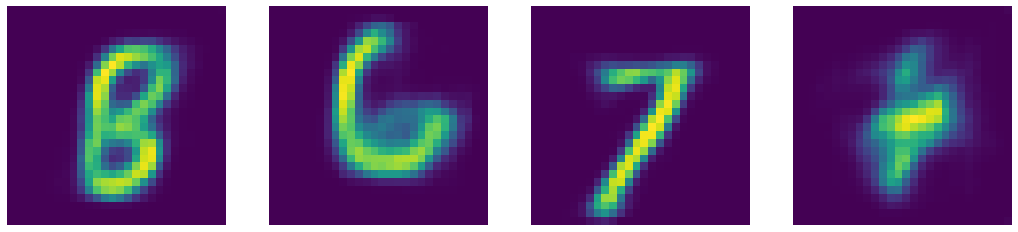

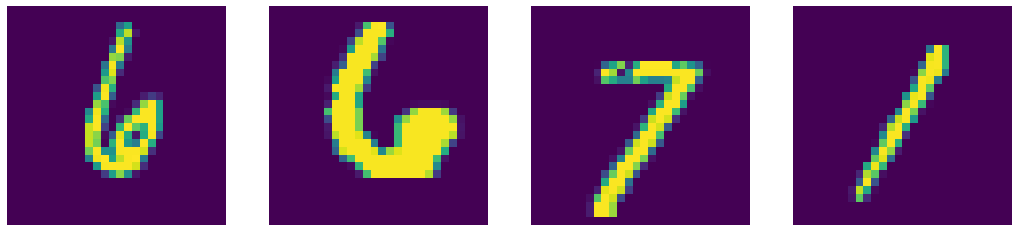

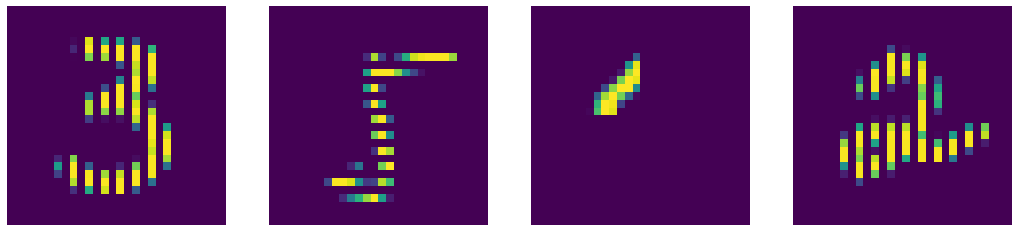

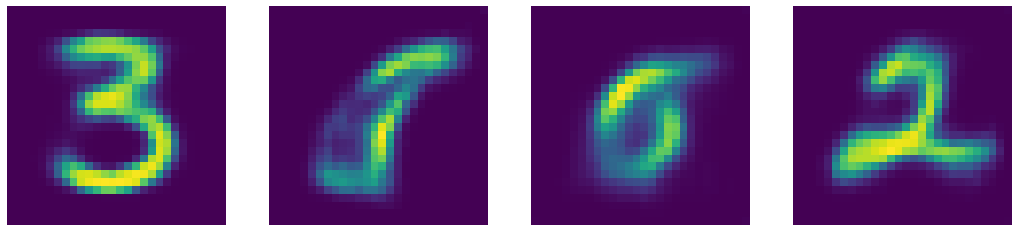

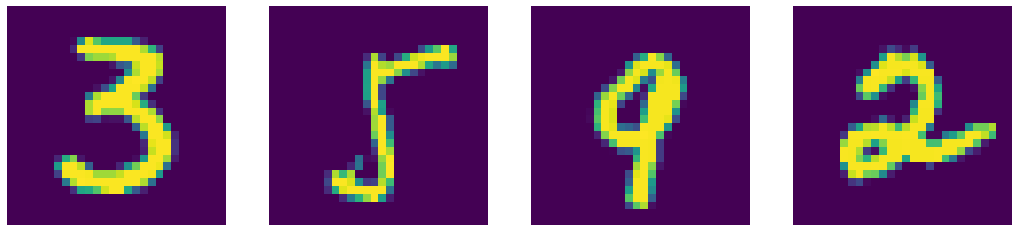

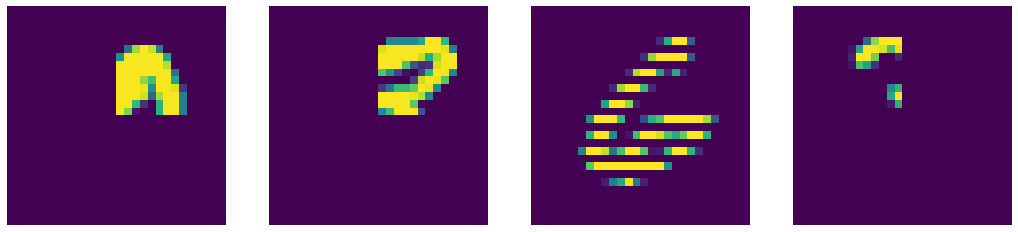

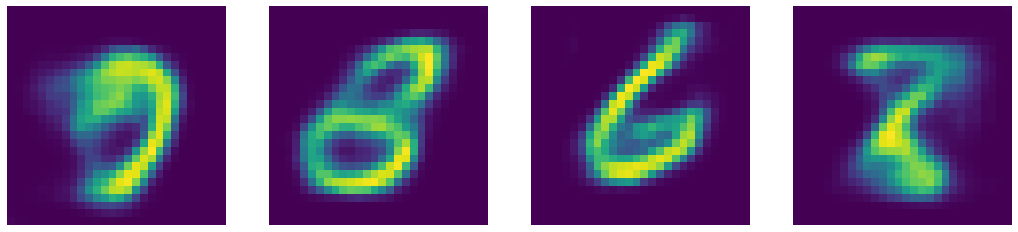

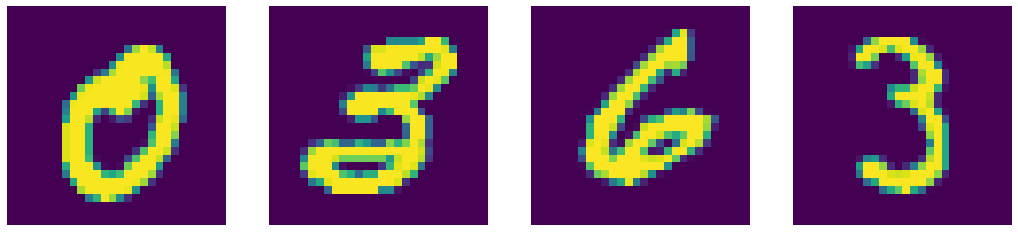

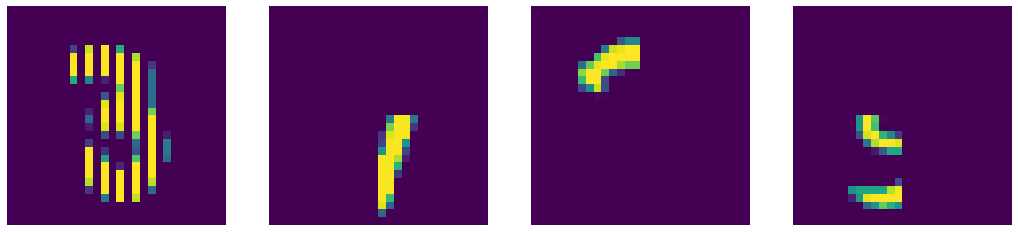

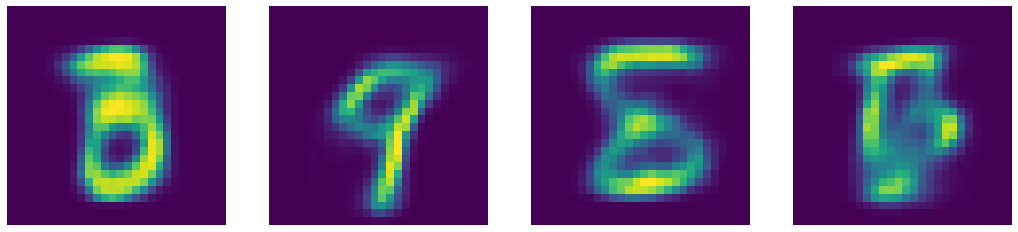

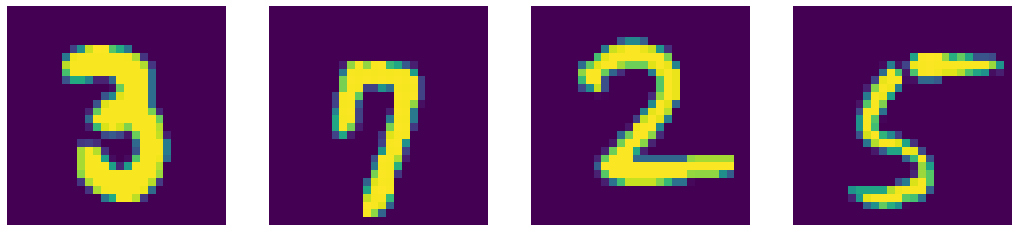

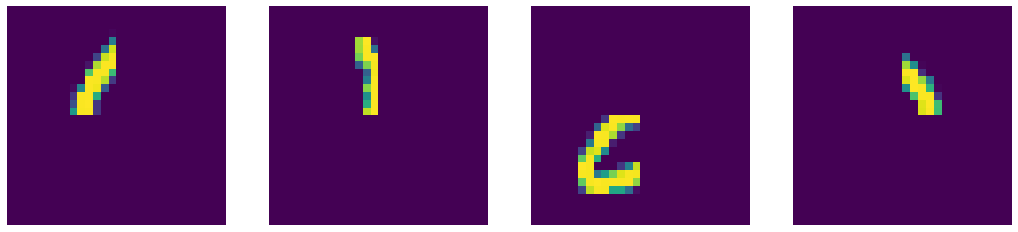

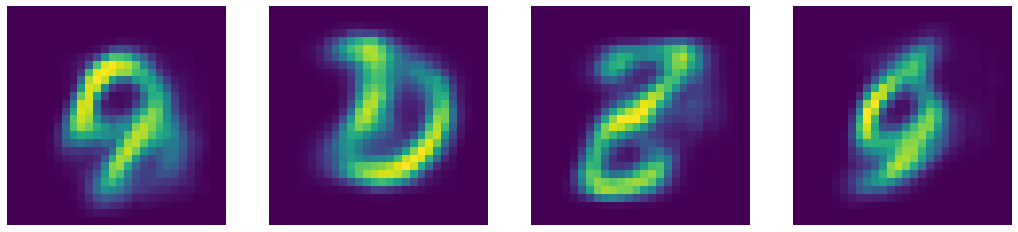

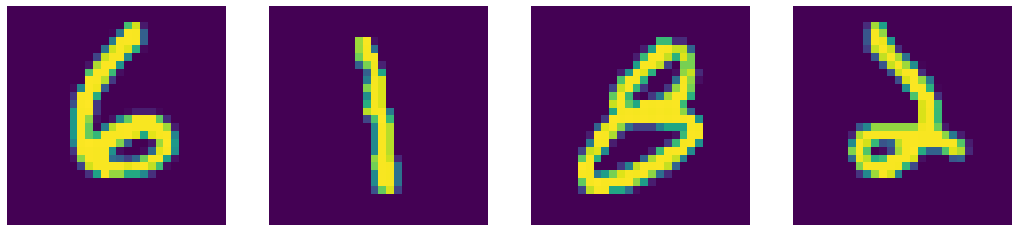

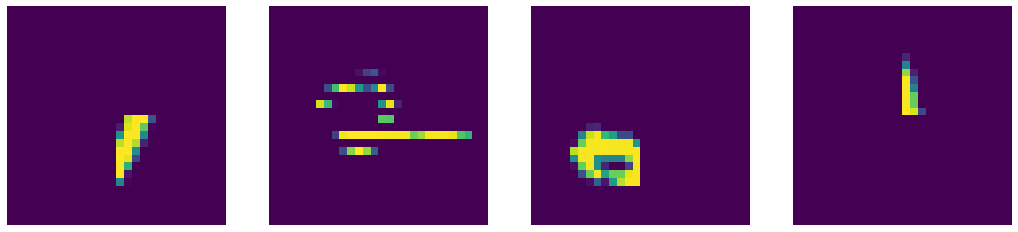

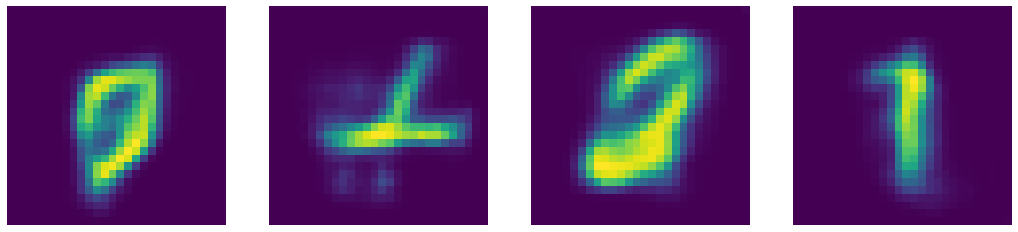

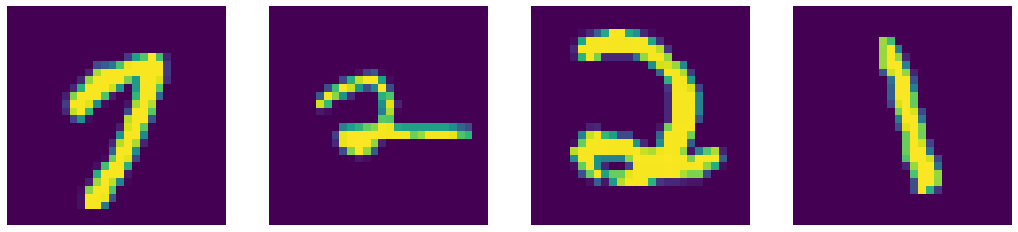

In [13]:
#centralized federated learning
for r in range(num_rounds):
    # select random clients
    client_idx = np.random.permutation(model_num)[:num_selected]
    train_loss = 0 
    test_loss=0
    # client update
    for i in (range(num_selected)):
        train_loss += client_update(client_models[i], opt[i], ds_train_loader[client_idx[i]], epochs)

    #aggregating models
    server_aggregate(global_model, client_models)

    test_loss = test(global_model, ds_test_loader)
    
    print('%d. round of updating and aggregating' % r)
    print('average train loss %0.3g | test loss %0.4g ' % (train_loss / num_selected / 60000, test_loss/10000))

In [14]:
print(client_models[7].state_dict())

IndexError: ignored